In [1]:
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier

In [2]:
param_dist = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'min_child_samples': [10, 20, 30]
}

In [3]:
pd.set_option('display.max_rows', None)

In [4]:
import os
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
from sklearn.preprocessing import label_binarize

def train_phase(phase_path, param_dist, n_iter=10, random_state=42, sample=False):
    best_model = None
    best_score = 0
    all_metrics = []
    best_params = None

    for fold in range(1, 6):
        fold_path = os.path.join(phase_path, f"fold{fold}")
        scaler = joblib.load(f"{fold_path}/scaler.pkl")
        
        if sample:
            X_train = pd.read_csv(f"{fold_path}/X_train_resampled.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train_resampled.csv").values.ravel()
            X_train_scaled = X_train
        else:
            X_train = pd.read_csv(f"{fold_path}/X_train.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train.csv").values.ravel()
            X_train_scaled = scaler.transform(X_train)
            X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
        
        X_val = pd.read_csv(f"{fold_path}/X_val.csv")
        y_val = pd.read_csv(f"{fold_path}/y_val.csv").values.ravel()
        X_val_scaled = scaler.transform(X_val)
        X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_train.columns)

        # Hyperparameter tuning on fold 1
        if fold == 1:
            clf = LGBMClassifier(random_state=random_state)
            search = RandomizedSearchCV(
                clf,
                param_distributions=param_dist,
                n_iter=n_iter,
                cv=3,
                n_jobs=-1,
                verbose=1,
                scoring='f1_macro'
            )
            search.fit(X_train_scaled, y_train)
            best_params = search.best_params_
            print(f"[Fold 1] Best Parameters Found: {best_params}")

        model = LGBMClassifier(**best_params, random_state=random_state)
        model.fit(X_train_scaled, y_train)

        y_pred = model.predict(X_val_scaled)
        y_proba = model.predict_proba(X_val_scaled)

        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='macro')

        # Compute multiclass AUC
        classes = model.classes_
        y_val_bin = label_binarize(y_val, classes=classes)
        auc = roc_auc_score(y_val_bin, y_proba, average='macro', multi_class='ovr')

        all_metrics.append({'fold': fold, 'accuracy': acc, 'f1_macro': f1, 'auc': auc})

        if f1 > best_score:
            best_score = f1
            best_model = model
            best_scaler = scaler
            best_fold = fold

        print(f"\nFold {fold} Classification Report:\n", classification_report(y_val, y_pred))

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        # Plot ROC Curve per class
        plt.figure(figsize=(8, 6))
        for i, cls in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
            plt.plot(fpr, tpr, label=f'Class {cls}')
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.title(f'ROC Curve - Fold {fold}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Print averages
    avg_metrics = pd.DataFrame(all_metrics).mean().to_dict()
    print(f"\nAverage Accuracy: {avg_metrics['accuracy']:.4f}")
    print(f"Average F1 Macro: {avg_metrics['f1_macro']:.4f}")
    print(f"Average AUC: {avg_metrics['auc']:.4f}")

    # Feature importance
    feature_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
    feature_importances = feature_importances.sort_values(ascending=False)
    print("\nTop Feature Importances:")
    print(feature_importances.head(10))

    return best_model, best_scaler, best_fold, all_metrics



=== Training Phase 1 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6565
[LightGBM] [Info] Number of data points in the train set: 7237, number of used features: 47
[LightGBM] [Info] Start training from score -0.418749
[LightGBM] [Info] Start training from score -1.504216
[LightGBM] [Info] Start training from score -2.353173
[LightGBM] [Info] Start training from score -3.830716
[LightGBM] [Info] Start training from score -5.751468
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5790
[LightGBM

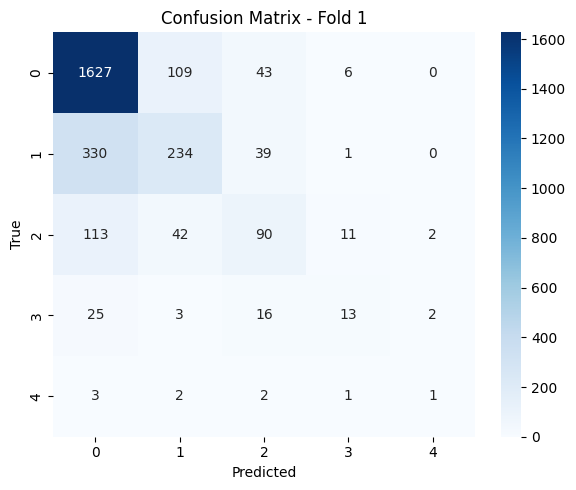

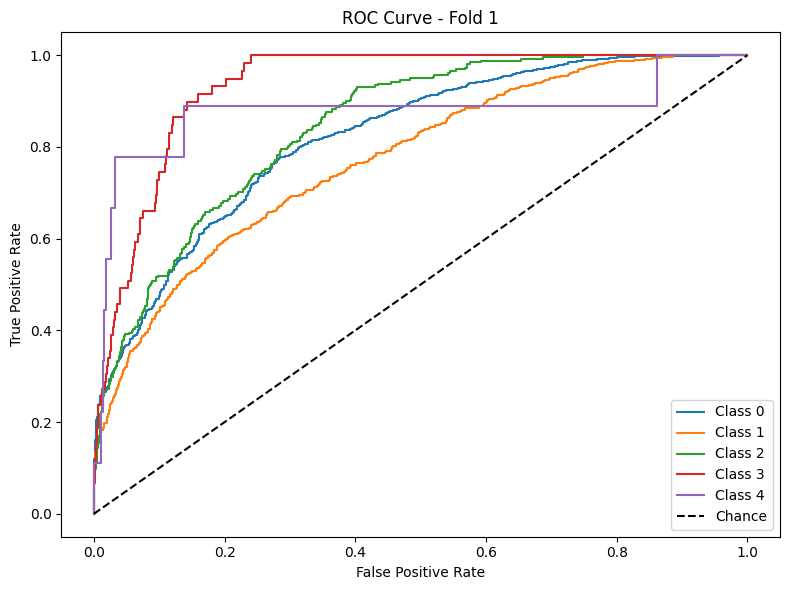

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6866
[LightGBM] [Info] Number of data points in the train set: 10857, number of used features: 48
[LightGBM] [Info] Start training from score -0.418957
[LightGBM] [Info] Start training from score -1.503939
[LightGBM] [Info] Start training from score -2.353311
[LightGBM] [Info] Start training from score -3.828734
[LightGBM] [Info] Start training from score -5.737217
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.91      0.83      1786
           1       0.57      0.34      0.43       603
           2       0.56      0.38      0.45       258
           3       0.35      0.20      0.26        59

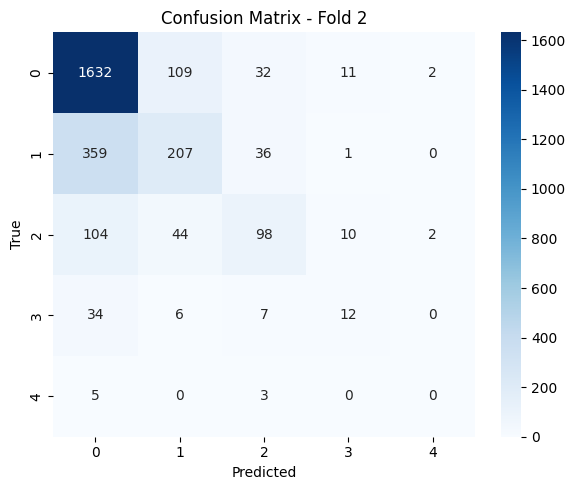

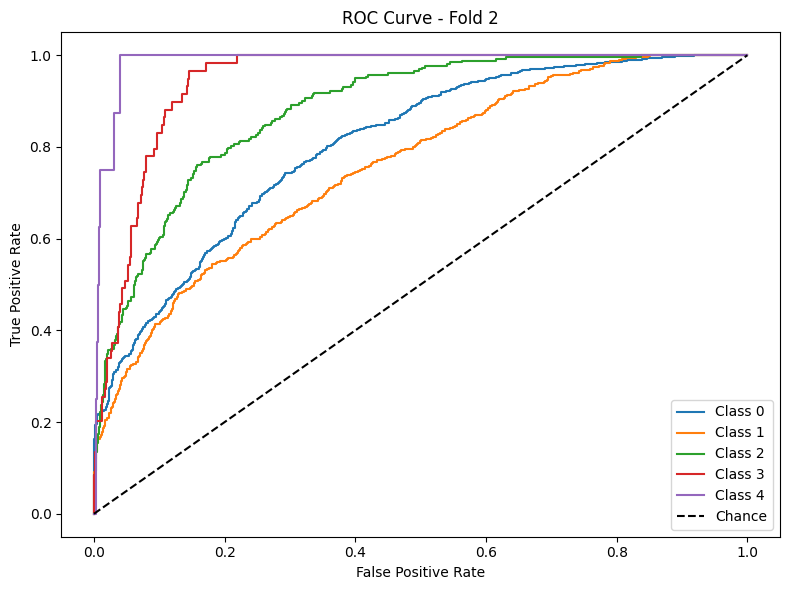

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6842
[LightGBM] [Info] Number of data points in the train set: 10857, number of used features: 48
[LightGBM] [Info] Start training from score -0.418957
[LightGBM] [Info] Start training from score -1.503939
[LightGBM] [Info] Start training from score -2.353311
[LightGBM] [Info] Start training from score -3.828734
[LightGBM] [Info] Start training from score -5.737217
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.90      0.83      1786
           1       0.61      0.40      0.48       603
           2       0.49      0.33      0.40       258
           3       0.45      0.22      0.30        59

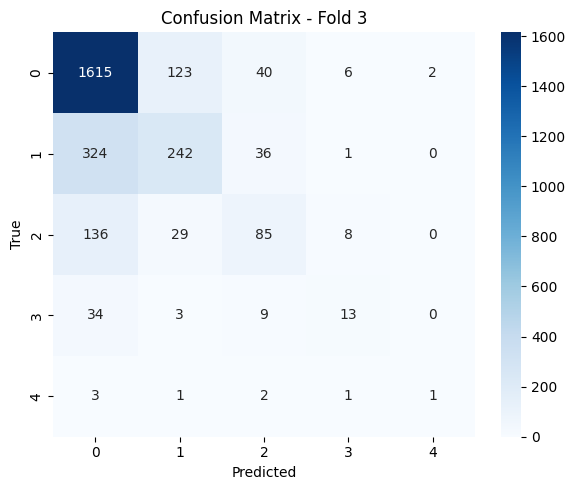

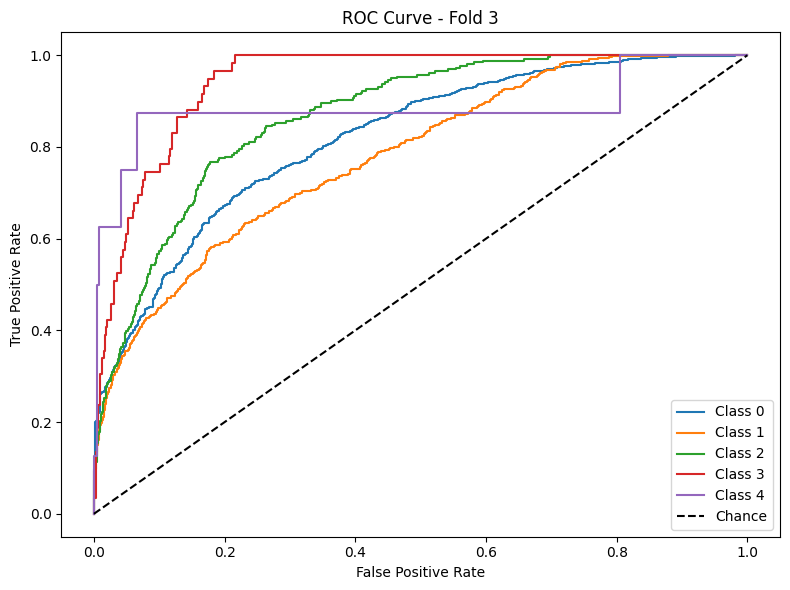

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6824
[LightGBM] [Info] Number of data points in the train set: 10857, number of used features: 48
[LightGBM] [Info] Start training from score -0.418817
[LightGBM] [Info] Start training from score -1.503939
[LightGBM] [Info] Start training from score -2.353311
[LightGBM] [Info] Start training from score -3.828734
[LightGBM] [Info] Start training from score -5.766205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.92      0.84      1785
           1       0.63      0.40      0.49       603
           2       0.59      0.3

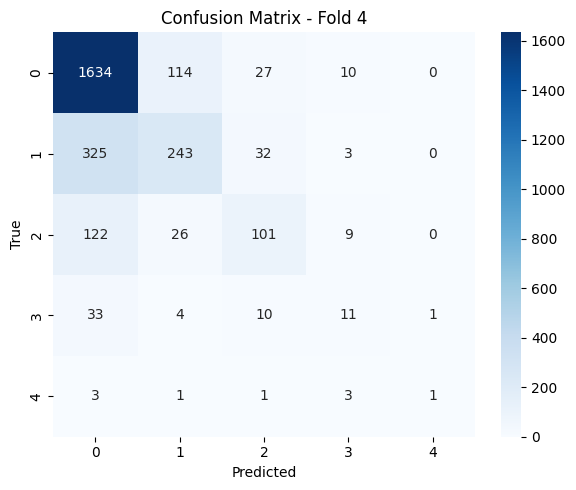

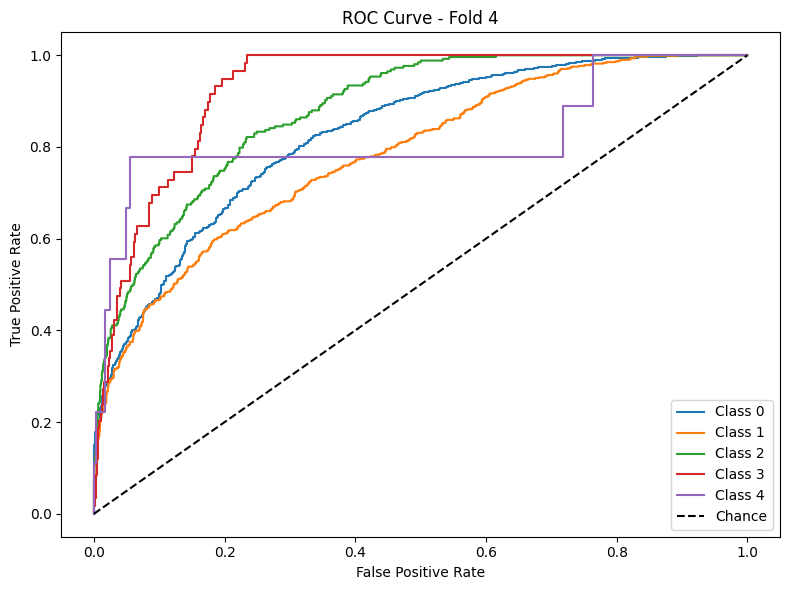

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6847
[LightGBM] [Info] Number of data points in the train set: 10857, number of used features: 48
[LightGBM] [Info] Start training from score -0.418817
[LightGBM] [Info] Start training from score -1.503939
[LightGBM] [Info] Start training from score -2.353311
[LightGBM] [Info] Start training from score -3.828734
[LightGBM] [Info] Start training from score -5.766205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.93      0.84      1785
           

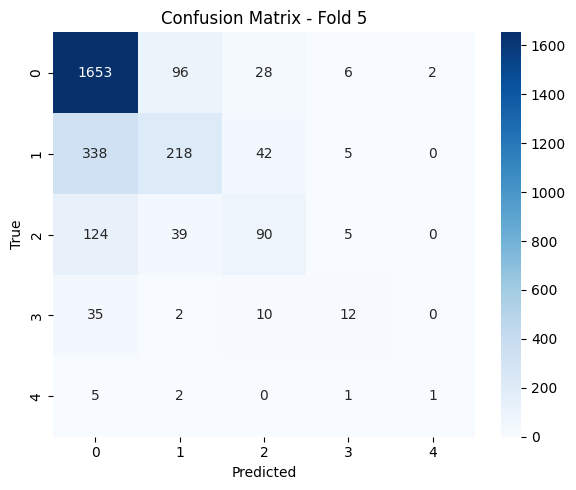

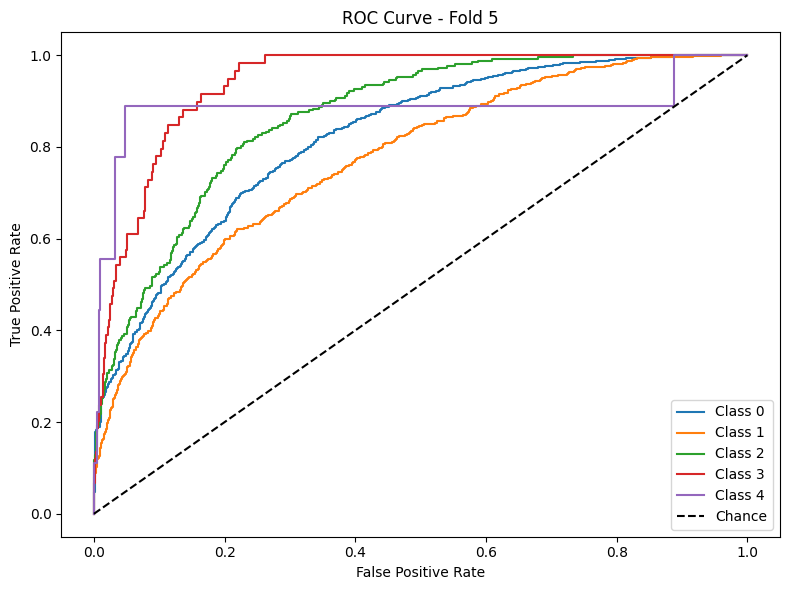


Average Accuracy: 0.7246
Average F1 Macro: 0.4264
Average AUC: 0.8576

Top Feature Importances:
remaining_time     1679
combined_emb_6     1525
combined_emb_14    1255
combined_emb_5     1206
combined_emb_11    1177
combined_emb_12    1157
combined_emb_9     1147
combined_emb_10    1145
combined_emb_8     1145
combined_emb_2     1141
dtype: int32

=== Training Phase 2 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

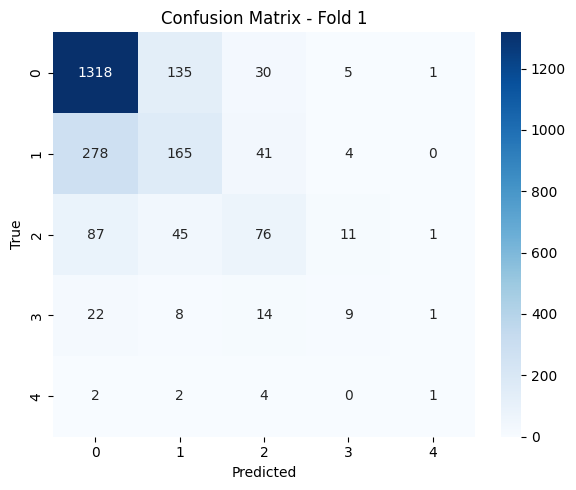

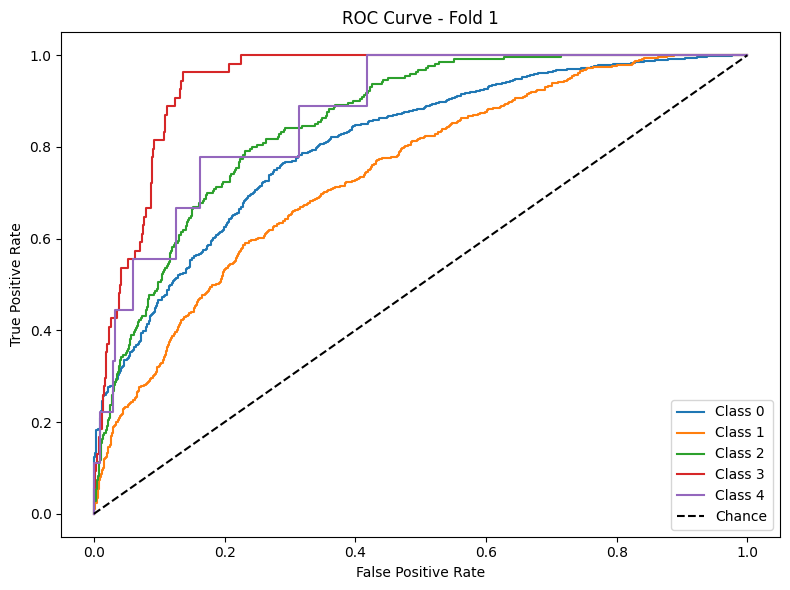

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6781
[LightGBM] [Info] Number of data points in the train set: 9037, number of used features: 64
[LightGBM] [Info] Start training from score -0.416760
[LightGBM] [Info] Start training from score -1.531449
[LightGBM] [Info] Start training from score -2.332576
[LightGBM] [Info] Start training from score -3.733804
[LightGBM] [Info] Start training from score -5.612575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

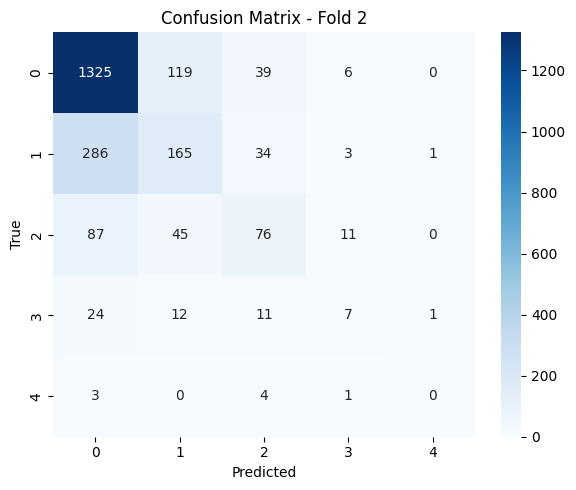

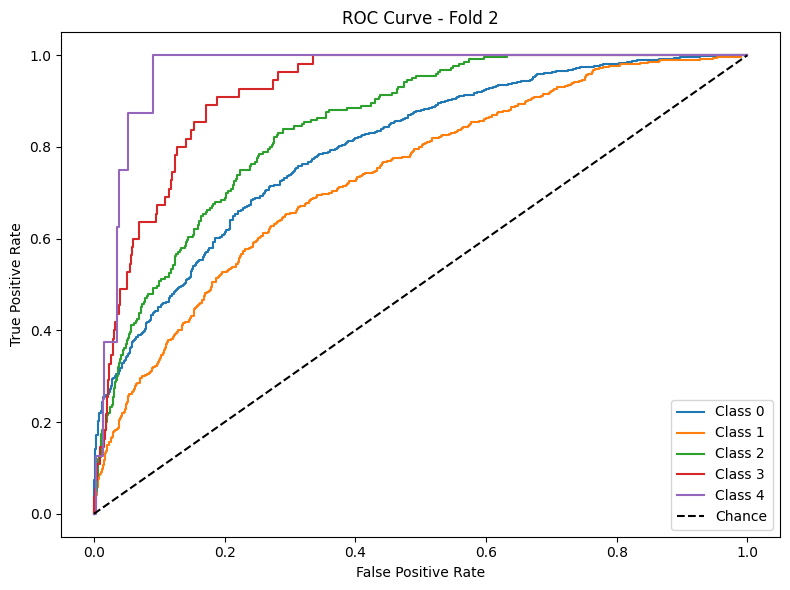

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6782
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 64
[LightGBM] [Info] Start training from score -0.416871
[LightGBM] [Info] Start training from score -1.531559
[LightGBM] [Info] Start training from score -2.332686
[LightGBM] [Info] Start training from score -3.729296
[LightGBM] [Info] Start training from score -5.612686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

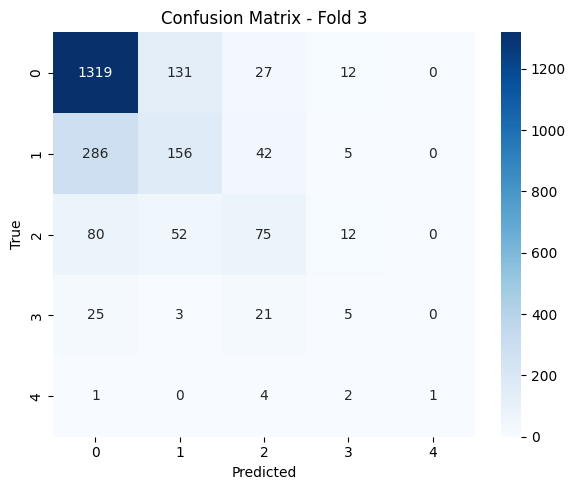

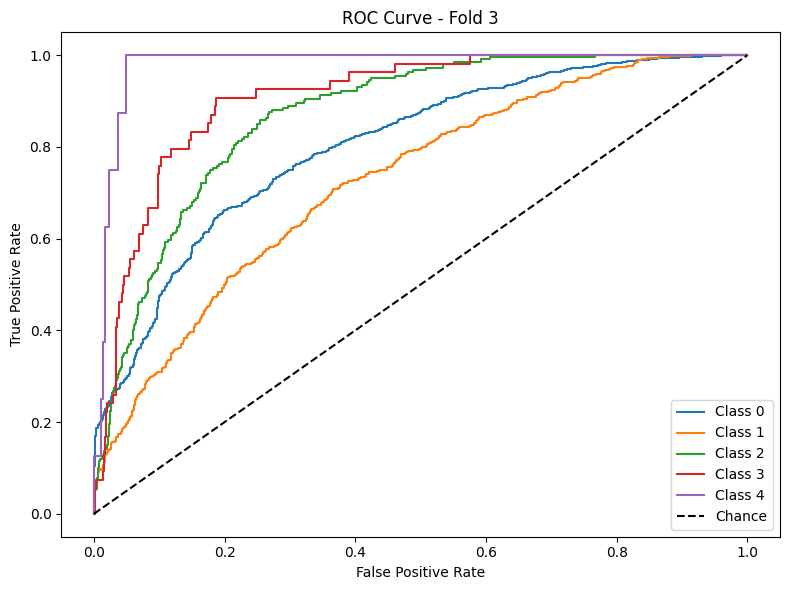

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6758
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 64
[LightGBM] [Info] Start training from score -0.416871
[LightGBM] [Info] Start training from score -1.531559
[LightGBM] [Info] Start training from score -2.332686
[LightGBM] [Info] Start training from score -3.729296
[LightGBM] [Info] Start training from score -5.612686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

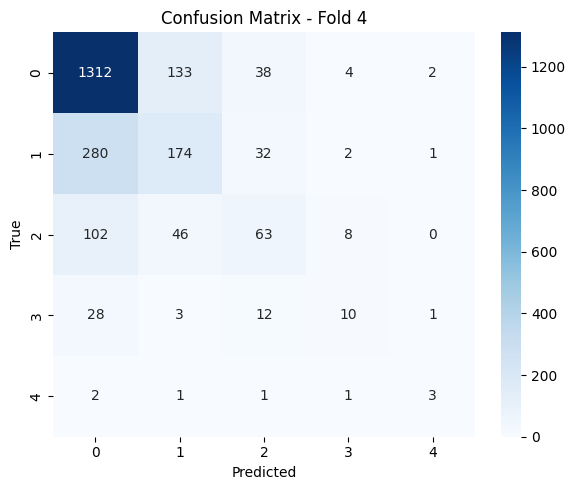

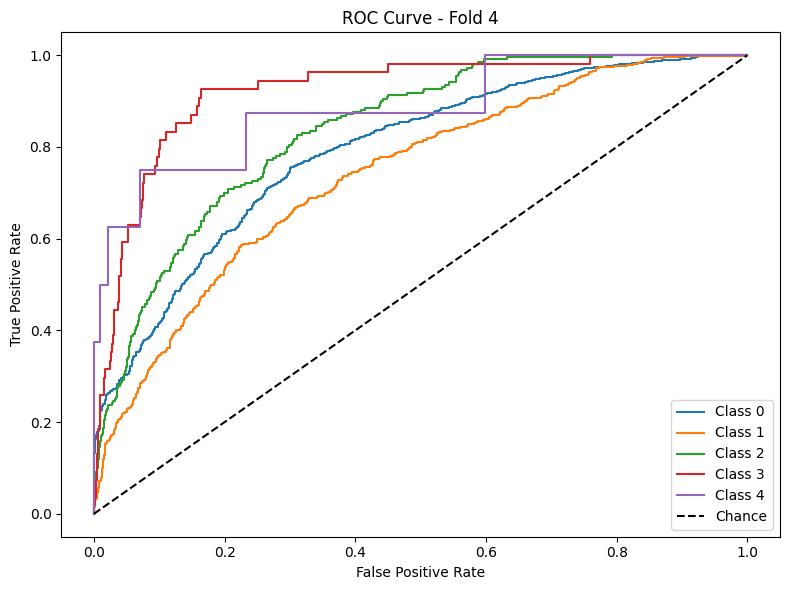

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6693
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 64
[LightGBM] [Info] Start training from score -0.417039
[LightGBM] [Info] Start training from score -1.531048
[LightGBM] [Info] Start training from score -2.332686
[LightGBM] [Info] Start training from score -3.729296
[LightGBM] [Info] Start training from score -5.612686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

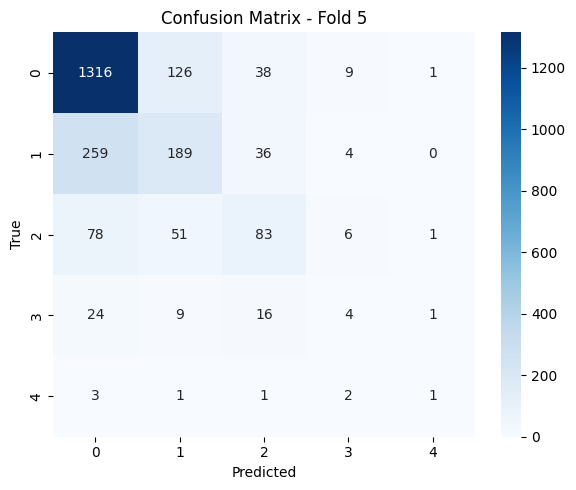

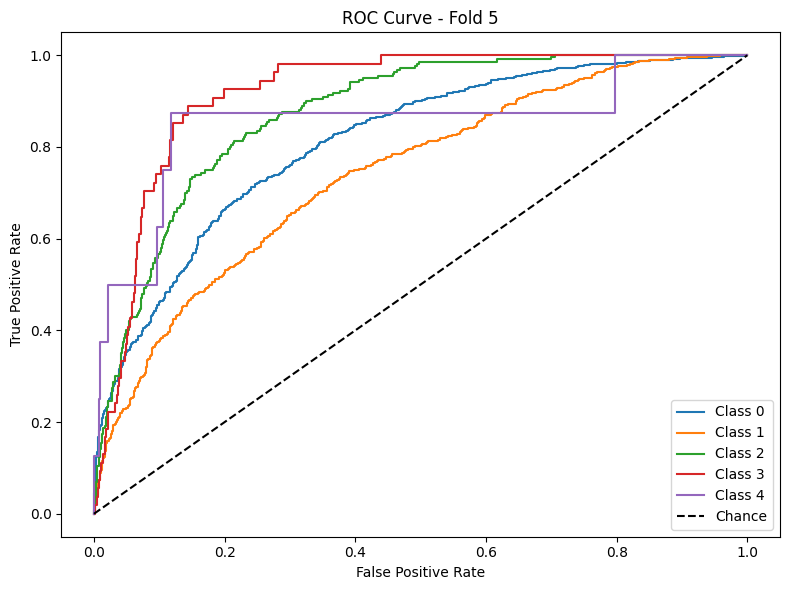


Average Accuracy: 0.6951
Average F1 Macro: 0.3949
Average AUC: 0.8457

Top Feature Importances:
combined_emb_0     10275
combined_emb_13    10183
combined_emb_2     10104
combined_emb_10     9924
combined_emb_4      9887
combined_emb_8      9879
combined_emb_11     9844
combined_emb_12     9800
combined_emb_3      9770
combined_emb_1      9735
dtype: int32

=== Training Phase 3 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.92      0.84      1361
           1       0.58      0.32      0.41       459
           2       0.45      0.35      0.39       198
           3       0.29      0.22      0.25        49
           4       0.00      0.00      0.00         7

    accuracy                           0.71      2074
   macro avg       0.42      0.36      0.38      2074
weighted avg       0.68      0.71      0.69      2074



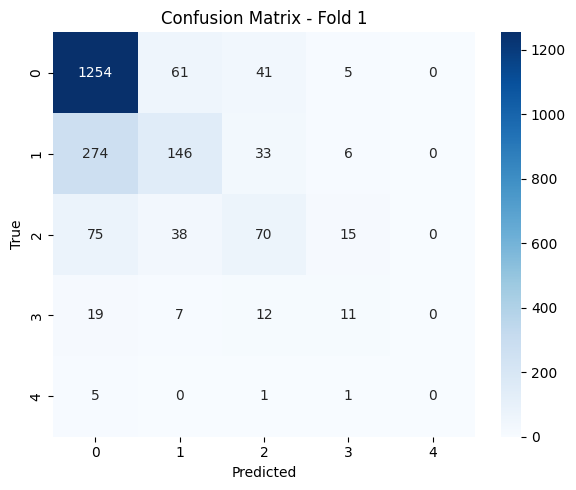

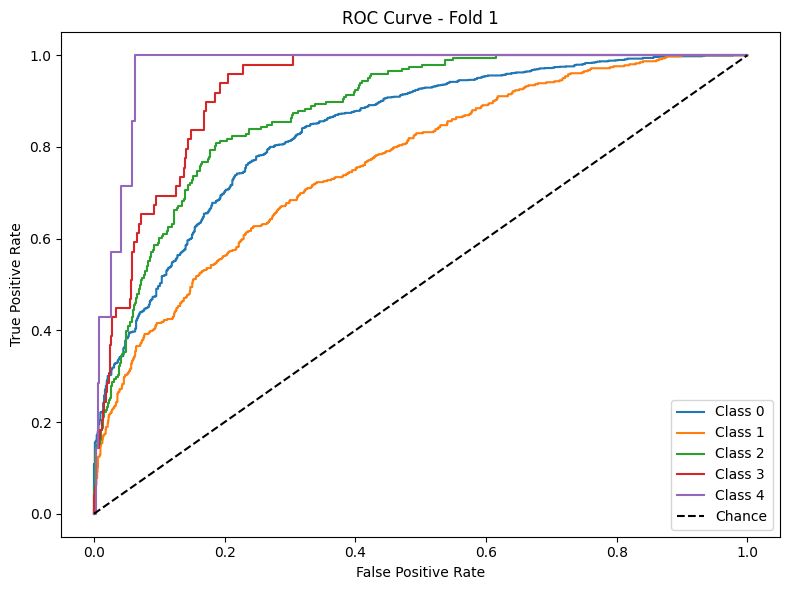

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7114
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 77
[LightGBM] [Info] Start training from score -0.421690
[LightGBM] [Info] Start training from score -1.507519
[LightGBM] [Info] Start training from score -2.350110
[LightGBM] [Info] Start training from score -3.735141
[LightGBM] [Info] Start training from score -5.691204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.91      0.83      1360
           1       0.52      0.32      0.40       459
           2       0.43      0.33      0.37       198
           3       0.40      0.20      0.27        50


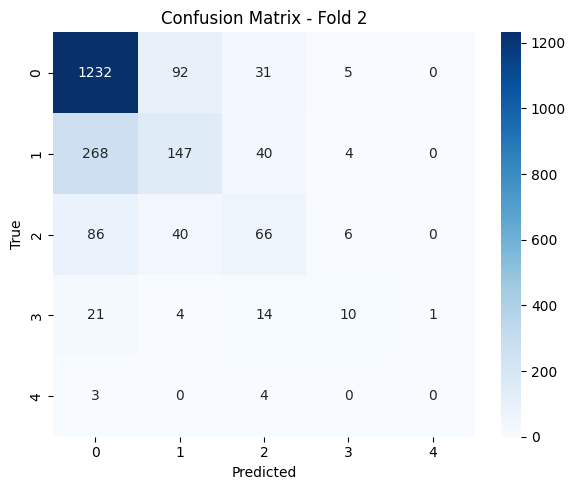

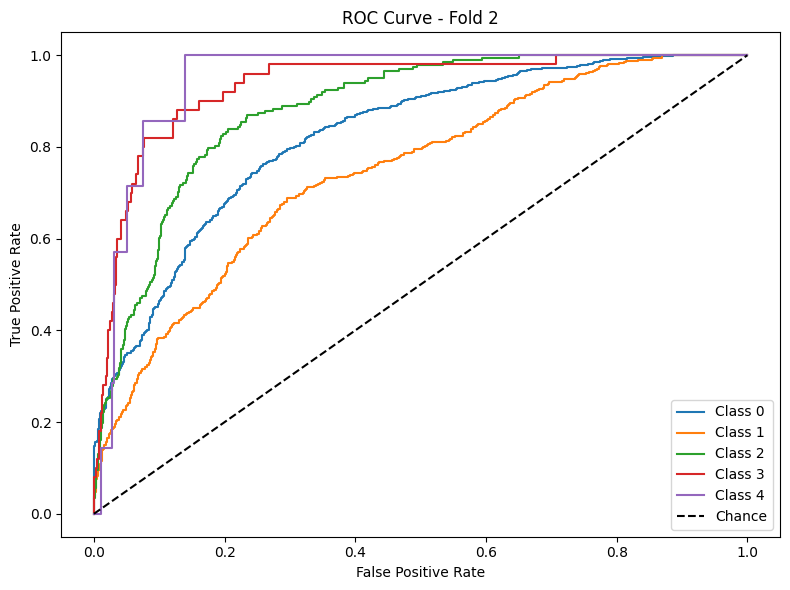

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7060
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 77
[LightGBM] [Info] Start training from score -0.421690
[LightGBM] [Info] Start training from score -1.507519
[LightGBM] [Info] Start training from score -2.350110
[LightGBM] [Info] Start training from score -3.735141
[LightGBM] [Info] Start training from score -5.691204

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.91      0.84      1360
           1       0.54      0.34      0.42       459
           2       0.43      0.36      0.39       198
           3       0.44      0.30      0.36        50
           4       0.00      0.00      0.00         7

    accuracy        

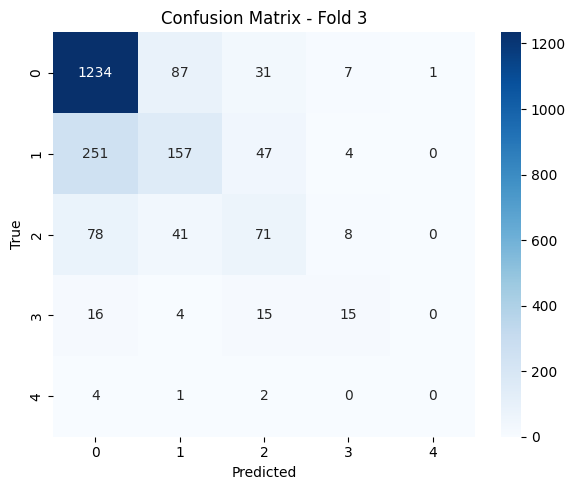

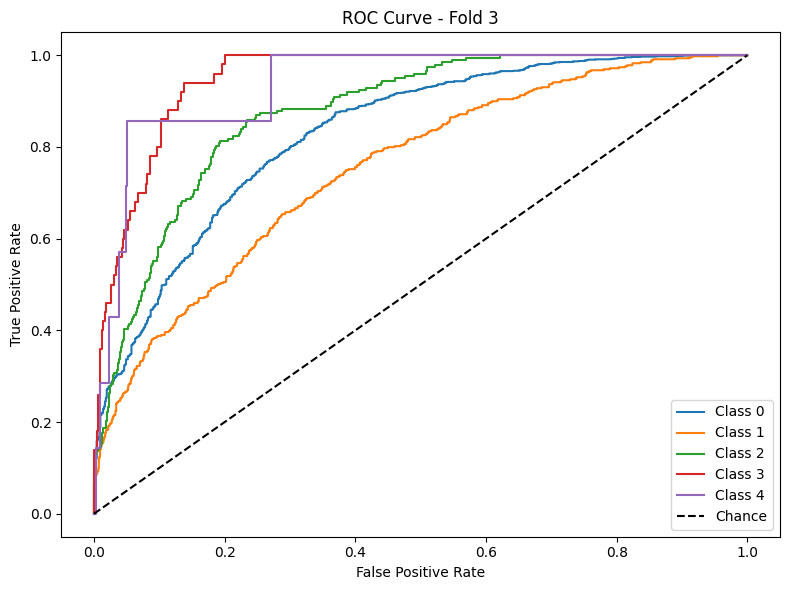

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7052
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 77
[LightGBM] [Info] Start training from score -0.421690
[LightGBM] [Info] Start training from score -1.507519
[LightGBM] [Info] Start training from score -2.350110
[LightGBM] [Info] Start training from score -3.735141
[LightGBM] [Info] Start training from score -5.691204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.91      0.83      1360
           1       0.53      0.33      0.41       459
           2       0.48      0.34      0.40       198
           3       0.35      0.18      0.24        50


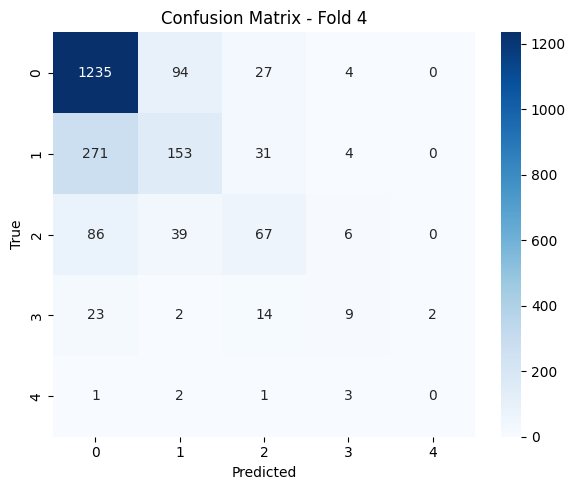

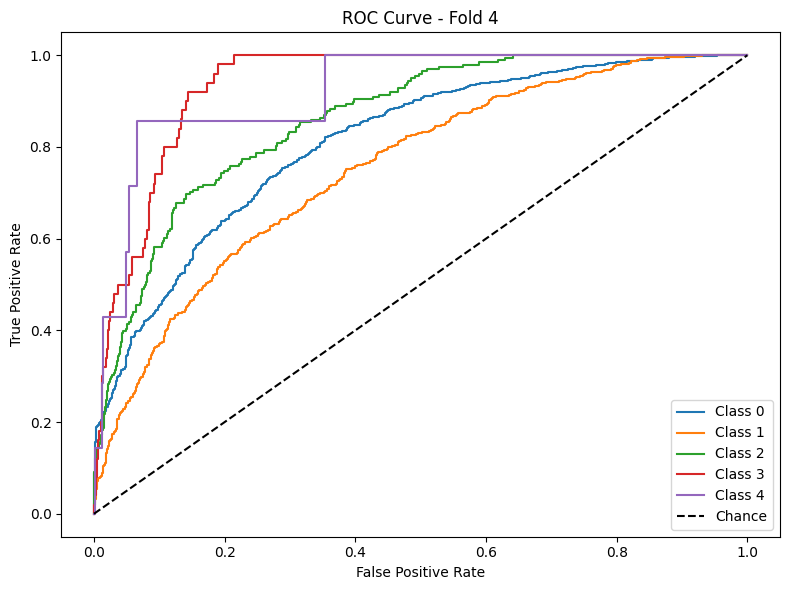

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7031
[LightGBM] [Info] Number of data points in the train set: 8296, number of used features: 77
[LightGBM] [Info] Start training from score -0.421811
[LightGBM] [Info] Start training from score -1.508184
[LightGBM] [Info] Start training from score -2.348967
[LightGBM] [Info] Start training from score -3.730224
[LightGBM] [Info] Start training from score -5.691324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.90      0.83      1360
           1       0.49      0.32      0.39       460
           2       0.40      0.29      0.34       197
           3       0.30      0.22      0.26        49


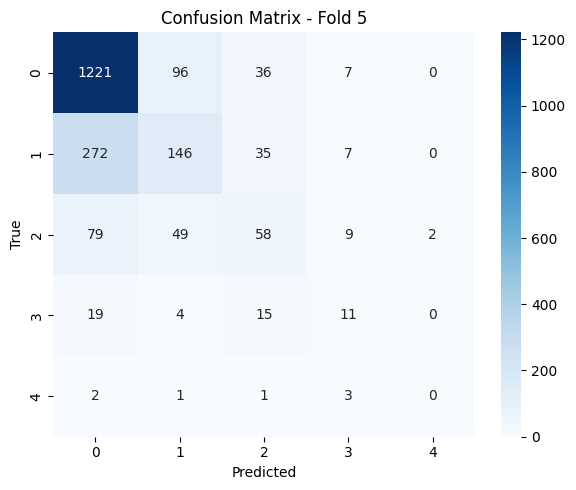

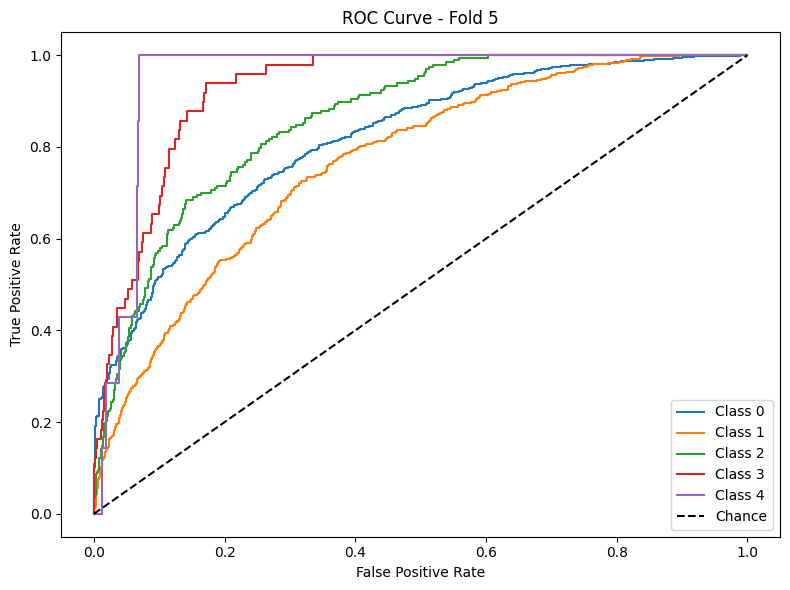


Average Accuracy: 0.7053
Average F1 Macro: 0.3780
Average AUC: 0.8662

Top Feature Importances:
combined_emb_9     792
remaining_time     766
combined_emb_3     756
combined_emb_2     727
combined_emb_6     724
combined_emb_11    713
combined_emb_13    690
combined_emb_4     666
combined_emb_8     662
combined_emb_12    650
dtype: int32

=== Training Phase 4 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

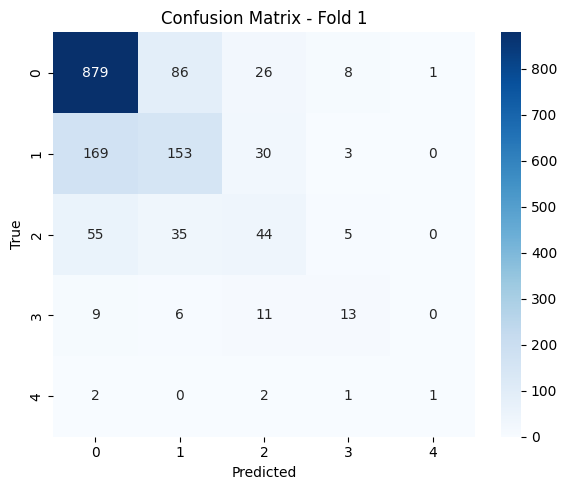

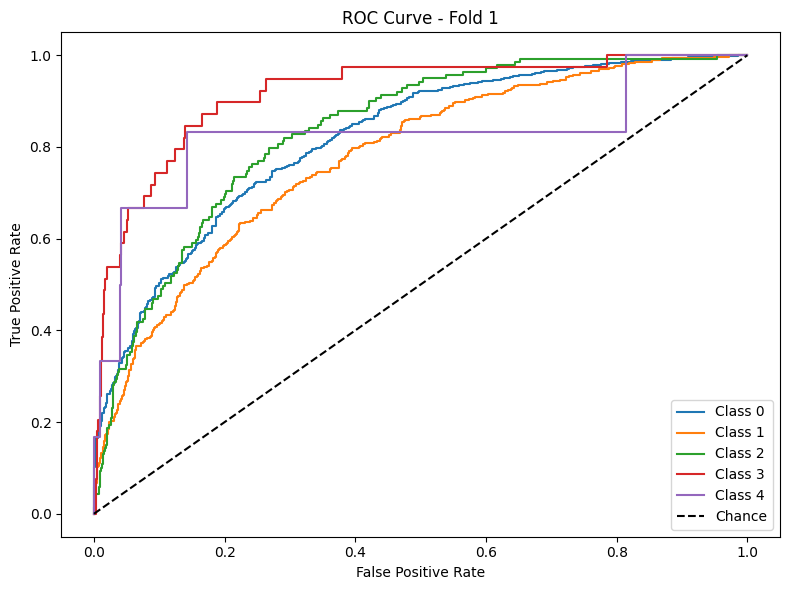

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8027
[LightGBM] [Info] Number of data points in the train set: 6154, number of used features: 94
[LightGBM] [Info] Start training from score -0.431558
[LightGBM] [Info] Start training from score -1.465038
[LightGBM] [Info] Start training from score -2.407693
[LightGBM] [Info] Start training from score -3.668612
[LightGBM] [Info] Start training from score -5.546804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

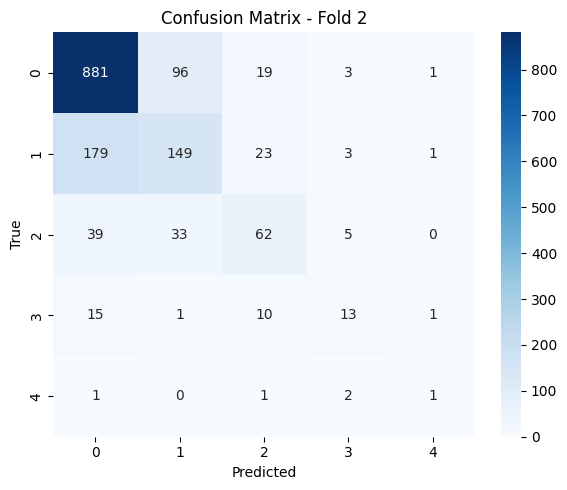

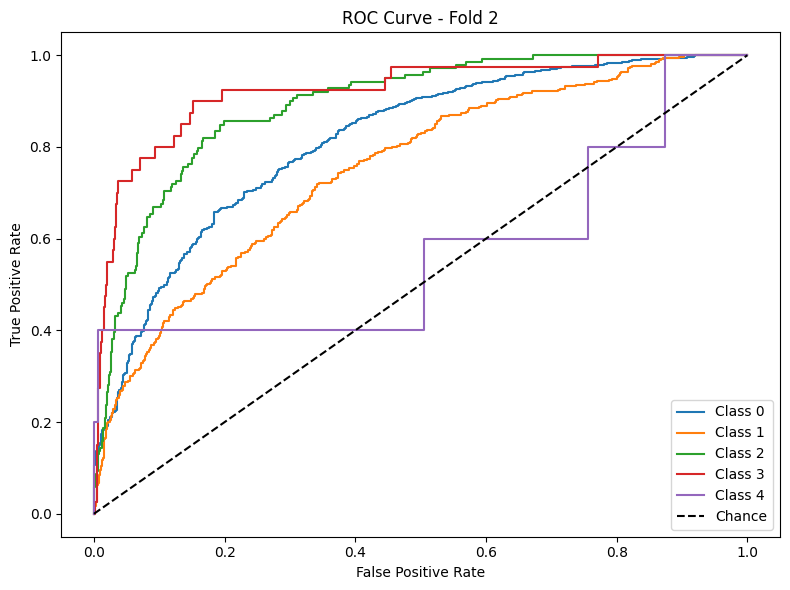

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8059
[LightGBM] [Info] Number of data points in the train set: 6154, number of used features: 94
[LightGBM] [Info] Start training from score -0.431308
[LightGBM] [Info] Start training from score -1.465038
[LightGBM] [Info] Start training from score -2.407693
[LightGBM] [Info] Start training from score -3.668612
[LightGBM] [Info] Start training from score -5.589363
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.89      0.84       999
           1       0.57      0.47      0.52       355
           2       0.50      0.37      0.43       139
           3       0.48      0.35      0.41        40
           4       0.00      0.00      0.00         6

    accuracy                           0.73      1539
   macro avg       0.47      0.42      0.44      1539
weighted avg       0.71      0.73      0.72      1539



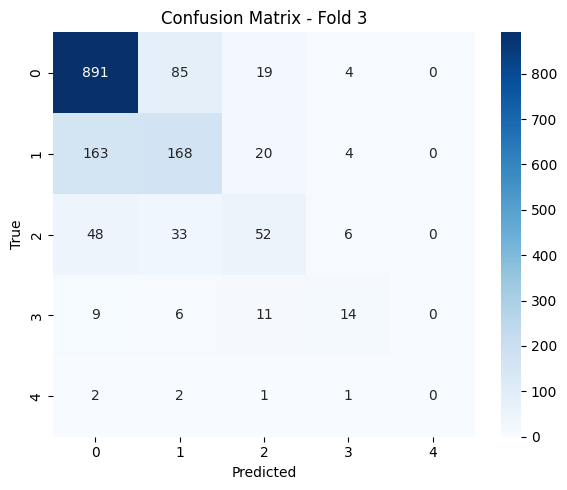

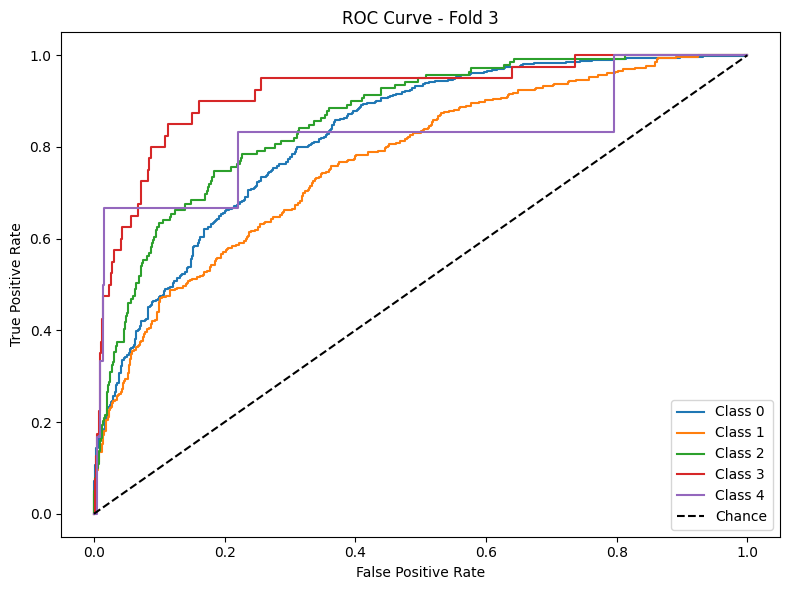

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8010
[LightGBM] [Info] Number of data points in the train set: 6155, number of used features: 94
[LightGBM] [Info] Start training from score -0.431471
[LightGBM] [Info] Start training from score -1.465904
[LightGBM] [Info] Start training from score -2.406052
[LightGBM] [Info] Start training from score -3.662425
[LightGBM] [Info] Start training from score -5.589526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

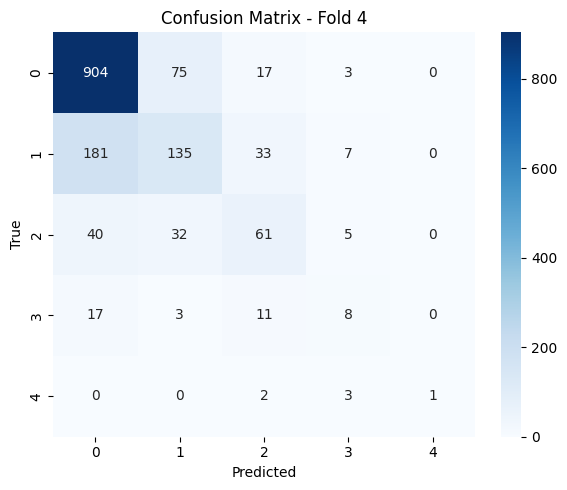

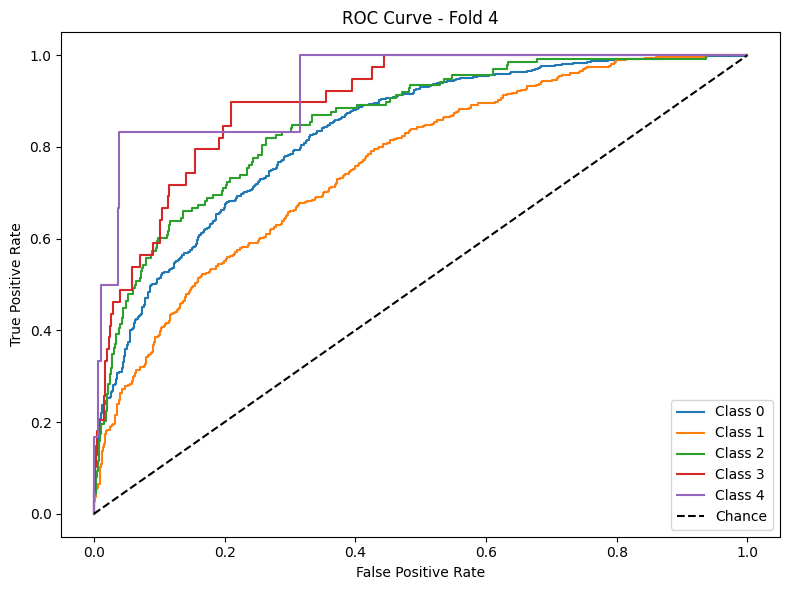

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8069
[LightGBM] [Info] Number of data points in the train set: 6155, number of used features: 95
[LightGBM] [Info] Start training from score -0.431471
[LightGBM] [Info] Start training from score -1.465904
[LightGBM] [Info] Start training from score -2.406052
[LightGBM] [Info] Start training from score -3.662425
[LightGBM] [Info] Start training from score -5.589526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

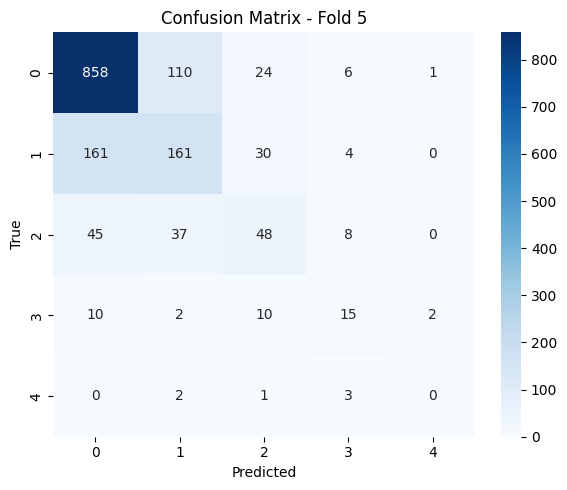

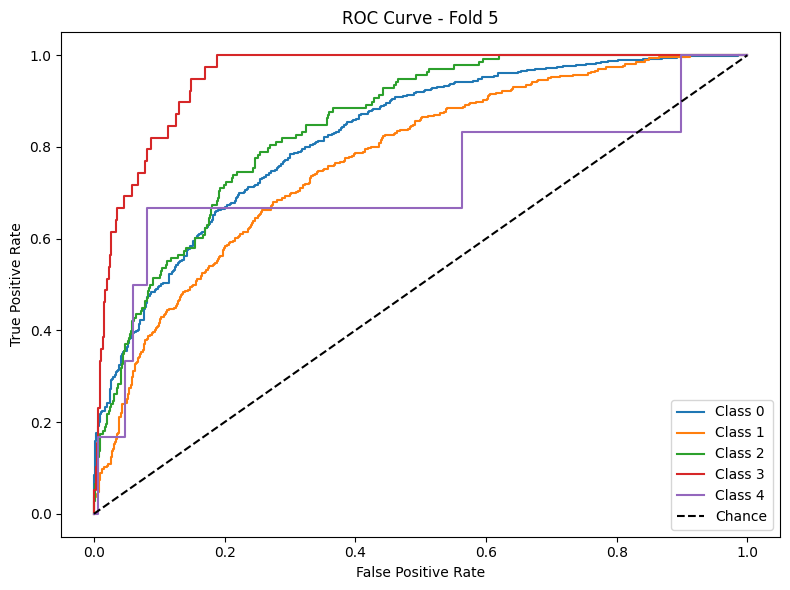


Average Accuracy: 0.7165
Average F1 Macro: 0.4511
Average AUC: 0.8283

Top Feature Importances:
combined_emb_7     8881
combined_emb_8     8820
combined_emb_6     8777
combined_emb_4     8703
combined_emb_12    8679
combined_emb_2     8474
combined_emb_10    8368
combined_emb_11    8293
combined_emb_3     8229
combined_emb_14    8210
dtype: int32


In [5]:
phase_paths = [f"/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n=== Training Phase {i} ===")
    sample = False
    model, scaler, best_fold, metrics = train_phase(phase_path, param_dist, sample = sample)
    # Save best model & scaler
    if sample: 
        temp = "sample"
    else: temp = "no_sample"
    joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    results[f"phase{i}"] = metrics


## Predict on Test Data

In [6]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

def predict_on_test(test_file_path, model_file, scaler_file, school_mapping_file):
    # Load model, scaler, and mapping
    model = joblib.load(model_file)
    scaler = joblib.load(scaler_file)
    mapping = joblib.load(school_mapping_file)

    # Load and preprocess test data
    df_test = pd.read_csv(test_file_path)
    y_test = df_test['label_encoded']
    X_test = df_test.drop(columns=['user_id', 'course_id', 'label_encoded', 'label', 'total_score'], axis=1)

    # Apply school mapping
    if 'school' in X_test.columns:
        X_test['school'] = X_test['school'].map(mapping).fillna(0).astype(int)

    # Scale features
    X_test_scaled = scaler.transform(X_test)

    # Predict
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # AUC Score
    classes = model.classes_
    y_test_bin = label_binarize(y_test, classes=classes)
    auc_score = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
    print(f"\nTest AUC (macro-average, OVR): {auc_score:.4f}")

    # Plot ROC Curves
    plt.figure(figsize=(8, 6))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        plt.plot(fpr, tpr, label=f'Class {cls}')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title('ROC Curves for Test Set')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return y_pred


Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       568
           1       0.38      0.29      0.33        63
           2       0.37      0.16      0.23        43
           3       1.00      0.07      0.12        15
           4       1.00      0.33      0.50         9

    accuracy                           0.83       698
   macro avg       0.73      0.36      0.42       698
weighted avg       0.80      0.83      0.80       698



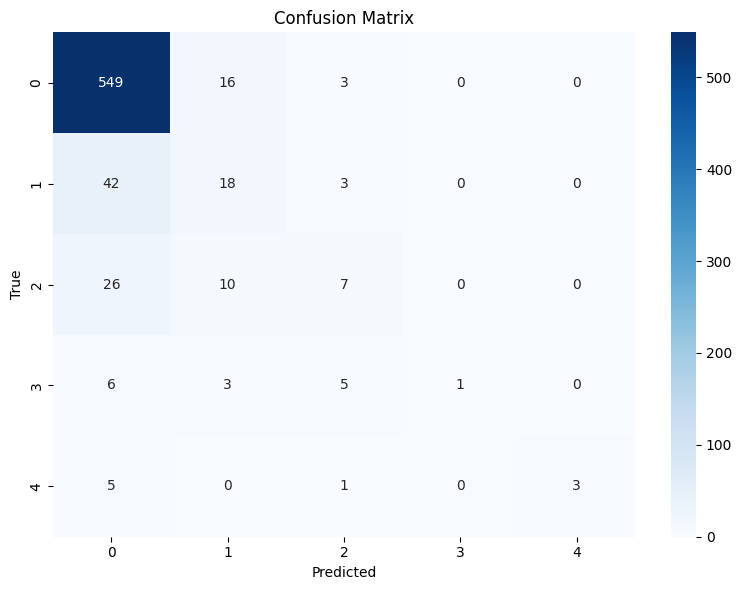


Test AUC (macro-average, OVR): 0.8432


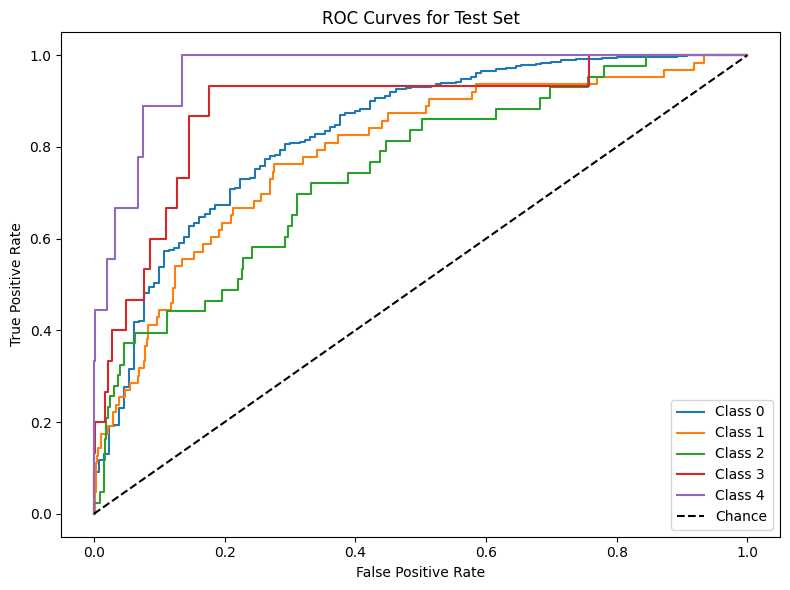


Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       544
           1       0.42      0.22      0.29        59
           2       0.31      0.24      0.27        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.82       668
   macro avg       0.32      0.28      0.30       668
weighted avg       0.77      0.82      0.79       668



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


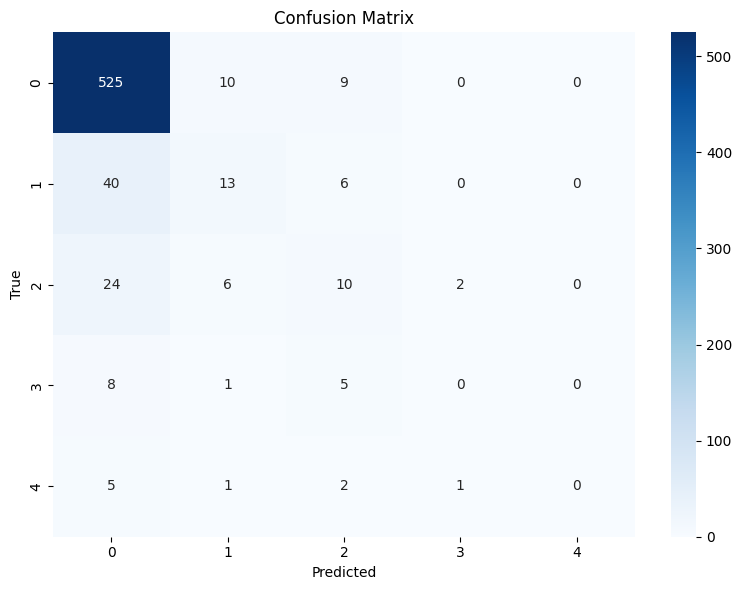


Test AUC (macro-average, OVR): 0.8636


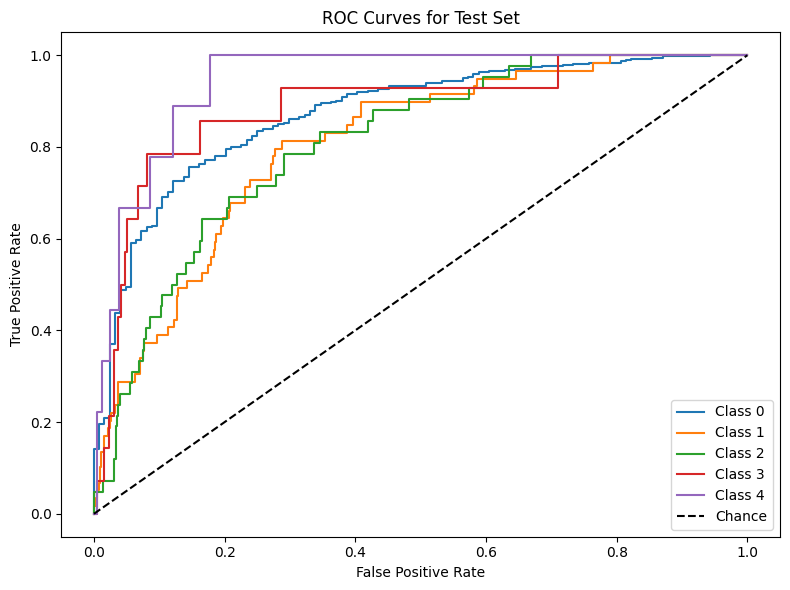


Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       455
           1       0.36      0.17      0.23        52
           2       0.25      0.17      0.20        29
           3       0.00      0.00      0.00        10
           4       0.67      0.25      0.36         8

    accuracy                           0.82       554
   macro avg       0.43      0.31      0.34       554
weighted avg       0.77      0.82      0.79       554



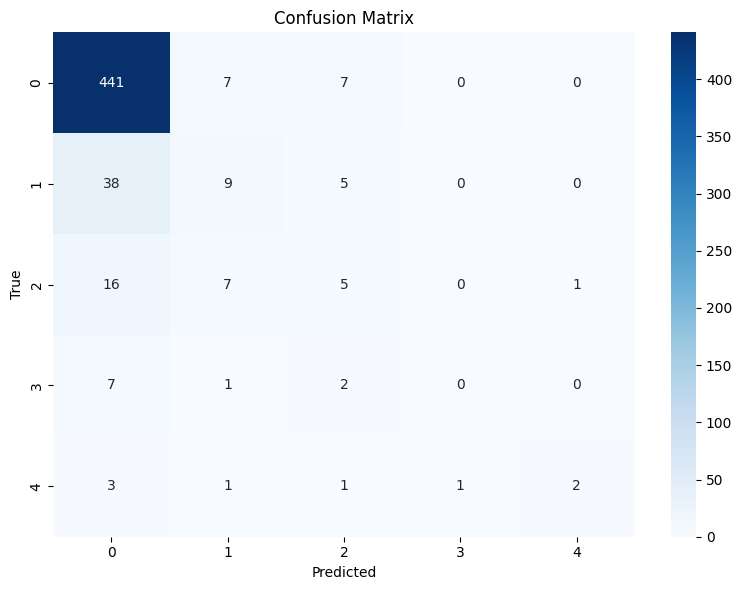


Test AUC (macro-average, OVR): 0.8611


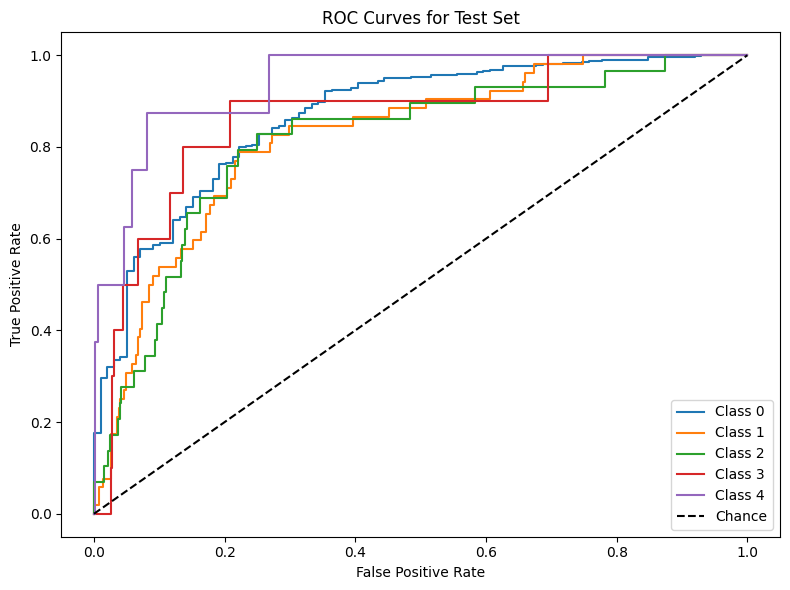


Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.95      0.91       395
           1       0.11      0.05      0.07        40
           2       0.29      0.25      0.27        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.81       477
   macro avg       0.25      0.25      0.25       477
weighted avg       0.74      0.81      0.77       477



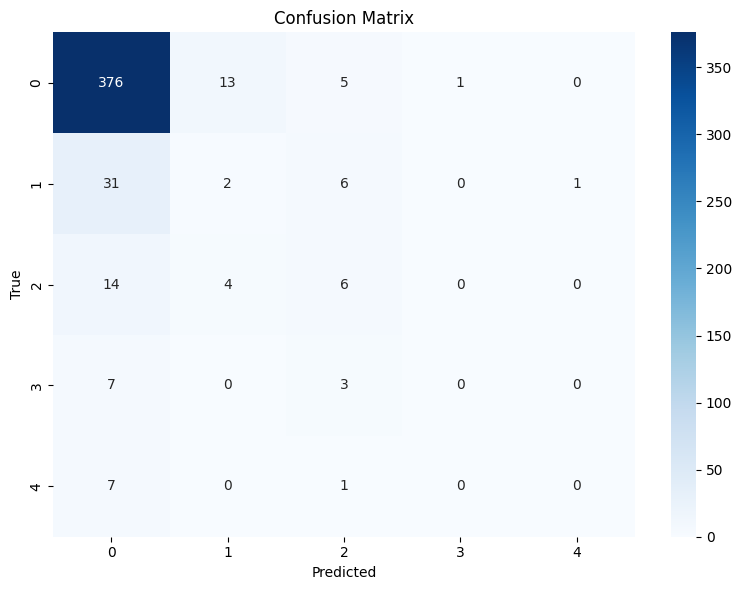


Test AUC (macro-average, OVR): 0.8100


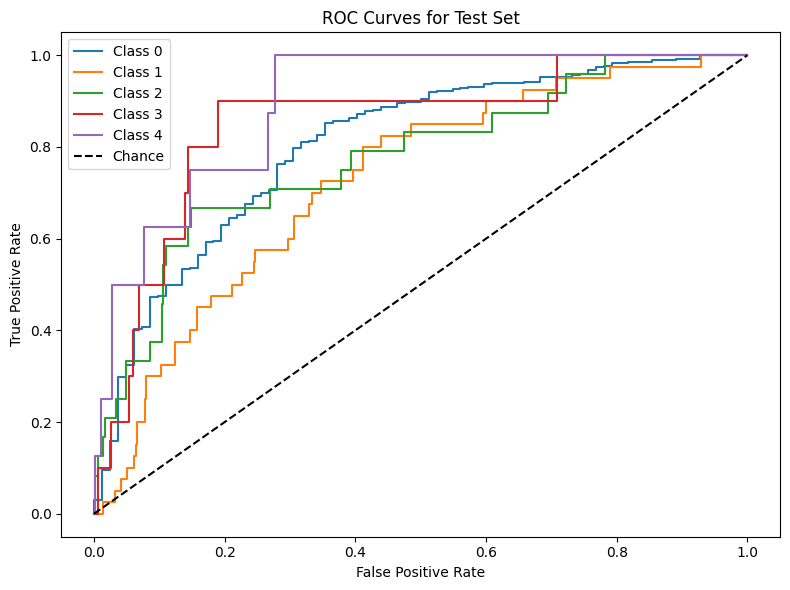

In [7]:
import glob

for i in range(1, 5):
    test_dir = f'/kaggle/input/enrich-data-using-node2vector/phase{i}/user_train_phase_{i}_test.csv'
    
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)


# Sample


=== Training Phase 1 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

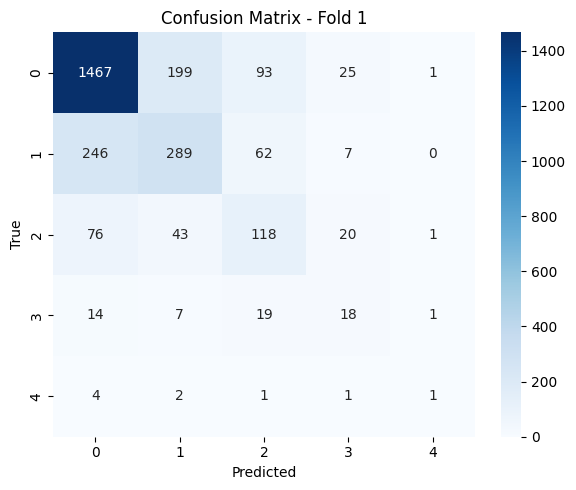

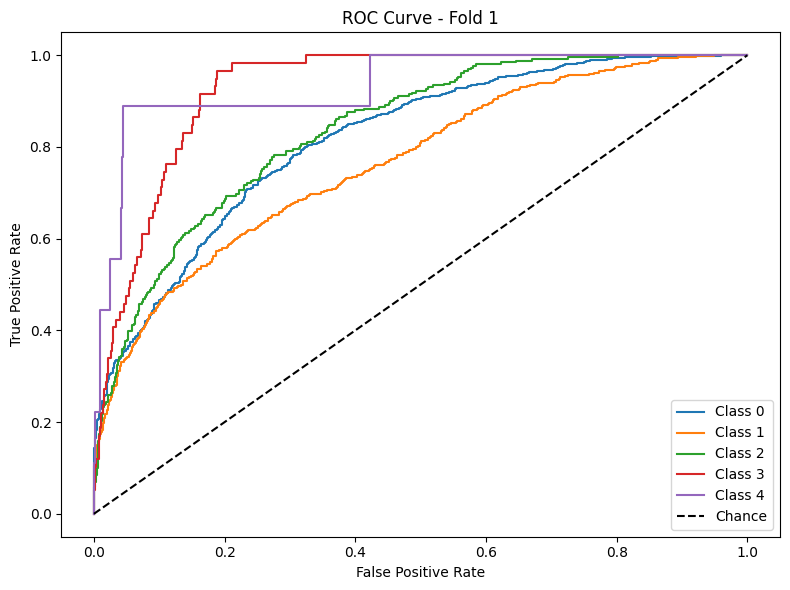

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11383
[LightGBM] [Info] Number of data points in the train set: 31580, number of used features: 48
[LightGBM] [Info] Start training from score -1.486671
[LightGBM] [Info] Start training from score -1.486671
[LightGBM] [Info] Start training from score -1.486671
[LightGBM] [Info] Start training from score -1.486671
[LightGBM] [Info] Start training from score -2.348593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

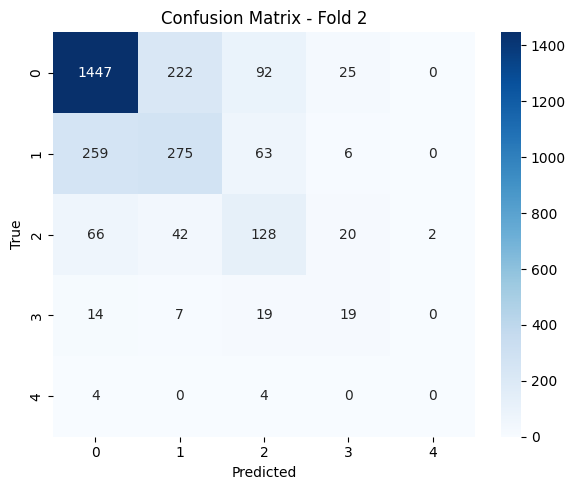

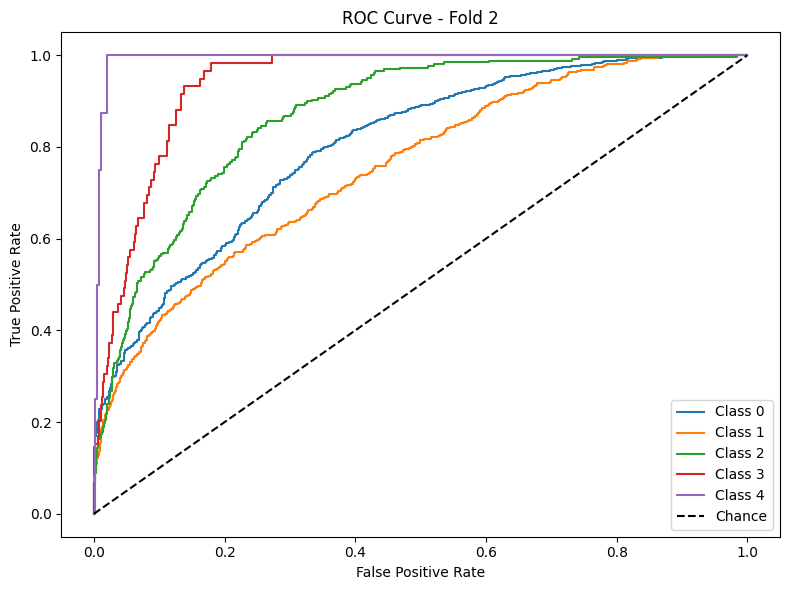

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11560
[LightGBM] [Info] Number of data points in the train set: 31580, number of used features: 48
[LightGBM] [Info] Start training from score -1.486671
[LightGBM] [Info] Start training from score -1.486671
[LightGBM] [Info] Start training from score -1.486671
[LightGBM] [Info] Start training from score -1.486671
[LightGBM] [Info] Start training from score -2.348593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

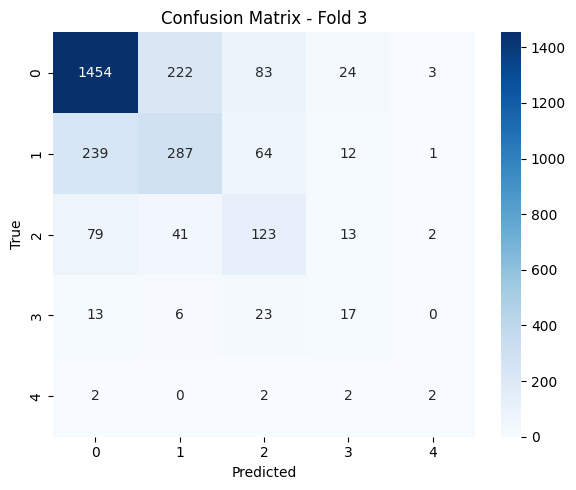

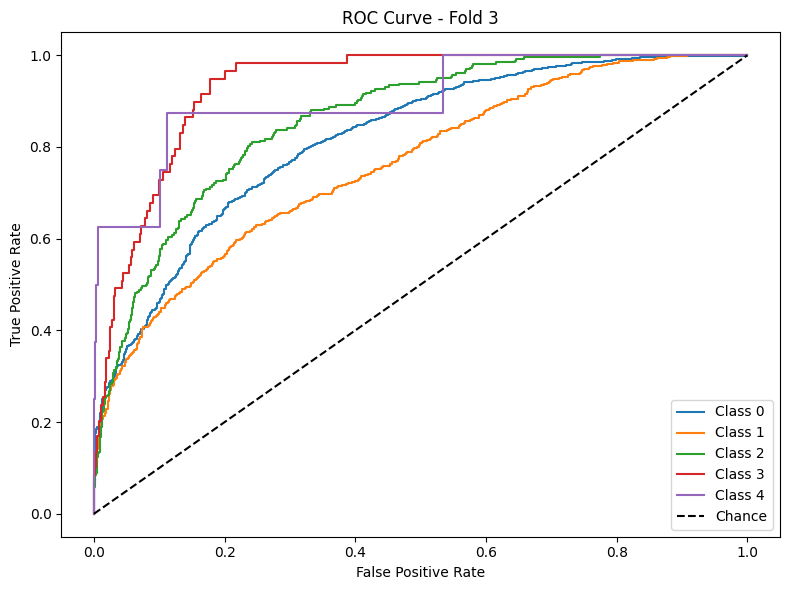

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11648
[LightGBM] [Info] Number of data points in the train set: 31584, number of used features: 48
[LightGBM] [Info] Start training from score -1.486658
[LightGBM] [Info] Start training from score -1.486658
[LightGBM] [Info] Start training from score -1.486658
[LightGBM] [Info] Start training from score -1.486658
[LightGBM] [Info] Start training from score -2.348719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

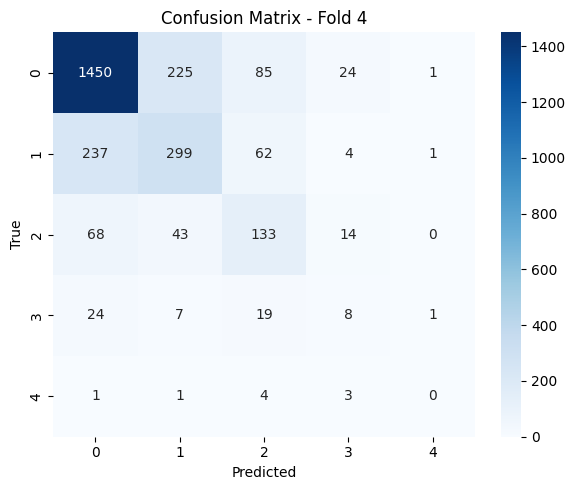

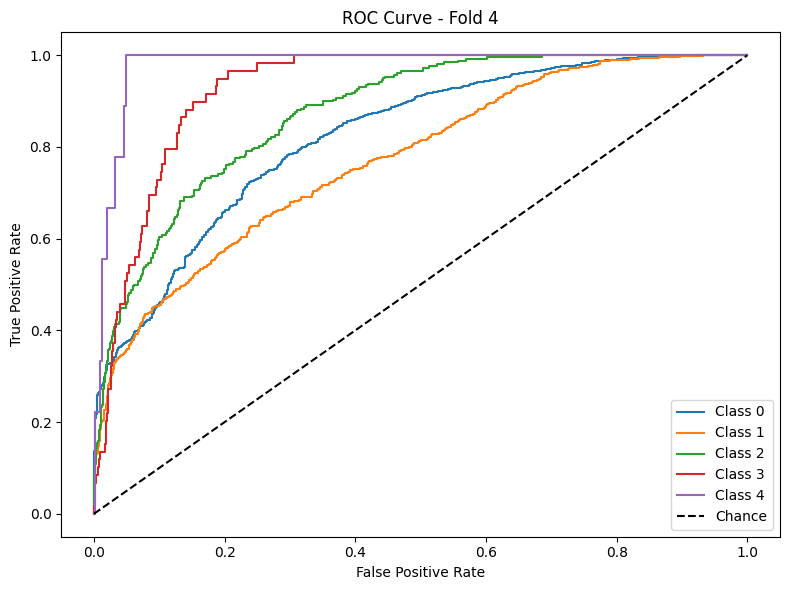

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11627
[LightGBM] [Info] Number of data points in the train set: 31584, number of used features: 48
[LightGBM] [Info] Start training from score -1.486658
[LightGBM] [Info] Start training from score -1.486658
[LightGBM] [Info] Start training from score -1.486658
[LightGBM] [Info] Start training from score -1.486658
[LightGBM] [Info] Start training from score -2.348719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

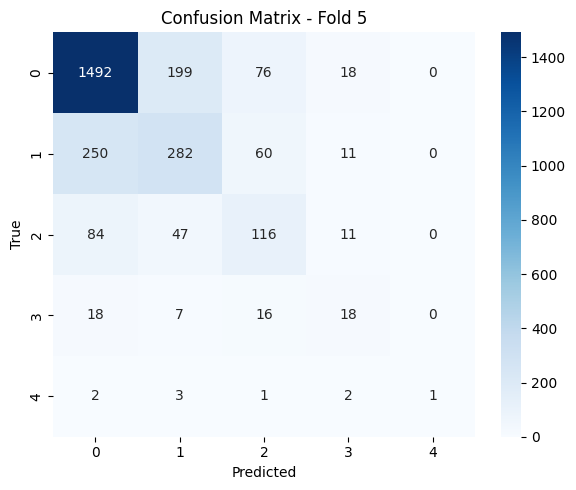

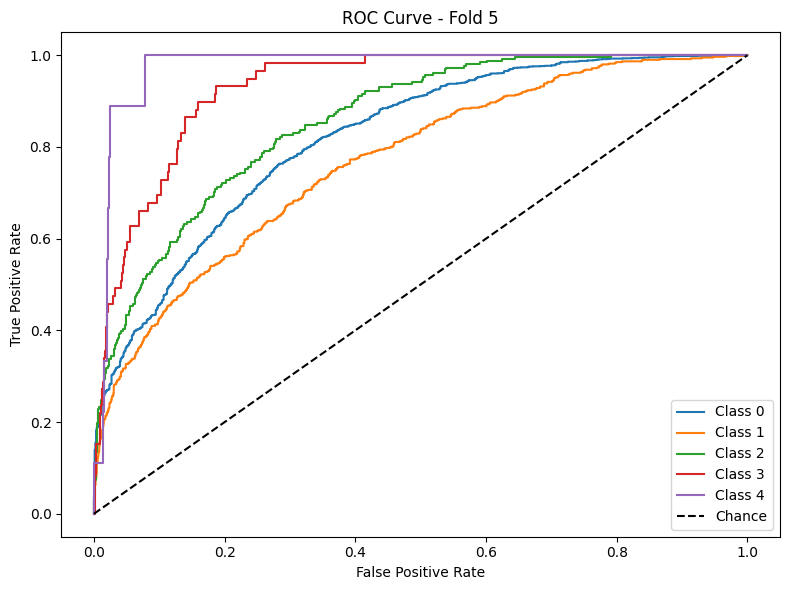


Average Accuracy: 0.6959
Average F1 Macro: 0.4275
Average AUC: 0.8658

Top Feature Importances:
remaining_time     8619
combined_emb_13    6090
combined_emb_2     5863
combined_emb_6     5844
combined_emb_12    5708
combined_emb_3     5590
combined_emb_9     5478
combined_emb_15    5466
combined_emb_1     5459
combined_emb_11    5409
dtype: int32

=== Training Phase 2 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[LightGBM] [Info] Total Bins 10940
[LightGBM] [Info] Number of data points in the train set: 21056, number of used features: 48
[LightGBM] [Info] Start training from score -1.486728
[LightGBM] [Info] Start training from score -1.486518
[LightGBM] [Info] Start training from score -1.486728
[LightGBM] [Info] Start training from score -1.486728
[LightGBM] [Info] Start training from score -2.348553
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[L

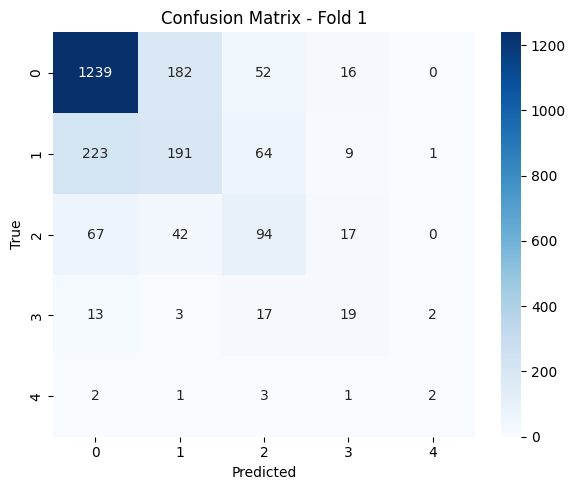

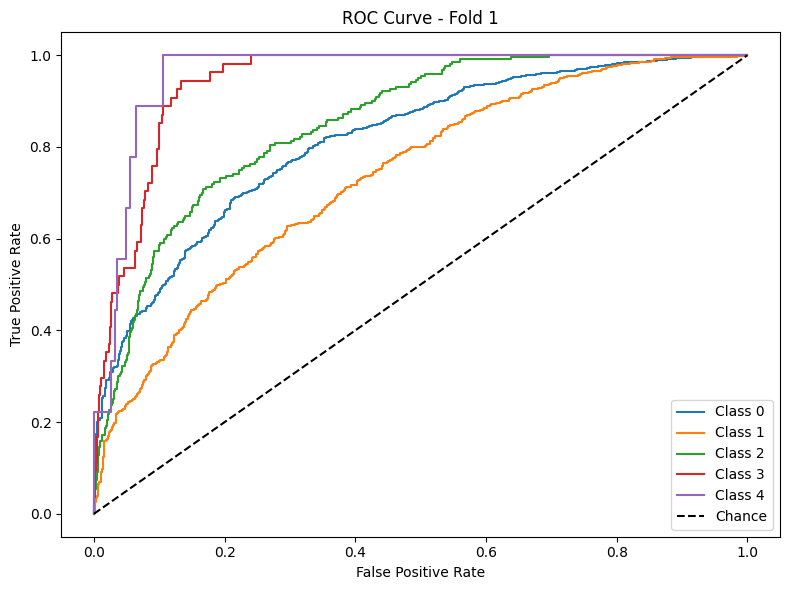

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14921
[LightGBM] [Info] Number of data points in the train set: 26346, number of used features: 64
[LightGBM] [Info] Start training from score -1.486749
[LightGBM] [Info] Start training from score -1.486749
[LightGBM] [Info] Start training from score -1.486749
[LightGBM] [Info] Start training from score -1.486749
[LightGBM] [Info] Start training from score -2.347852
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

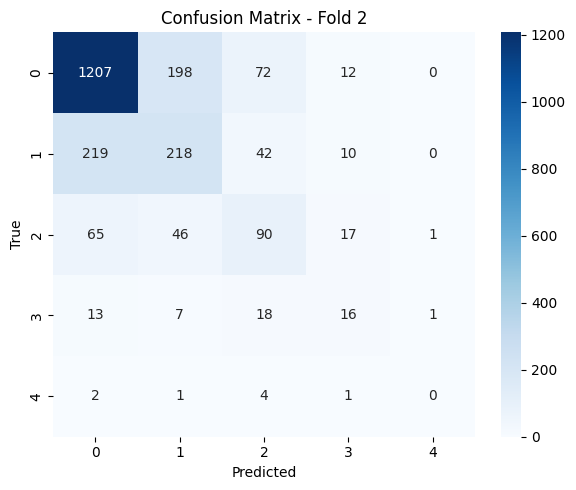

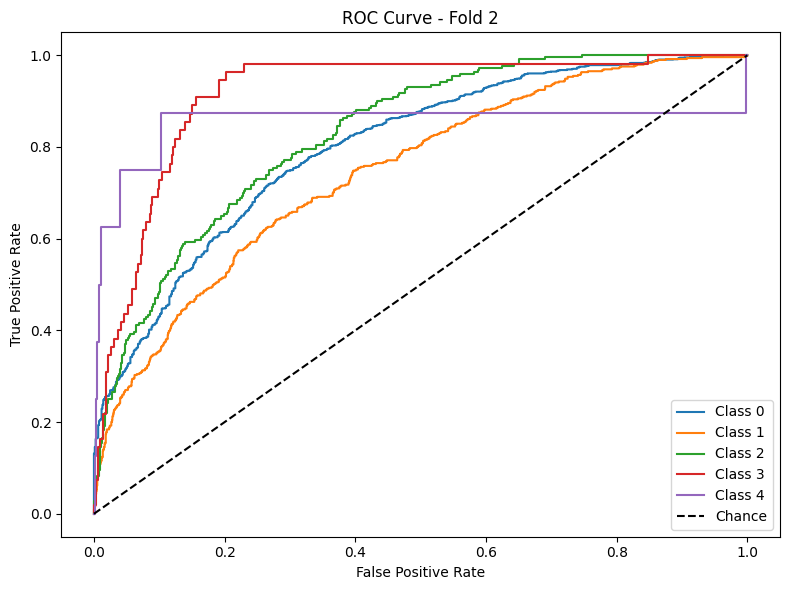

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14877
[LightGBM] [Info] Number of data points in the train set: 26346, number of used features: 64
[LightGBM] [Info] Start training from score -1.486749
[LightGBM] [Info] Start training from score -1.486749
[LightGBM] [Info] Start training from score -1.486749
[LightGBM] [Info] Start training from score -1.486749
[LightGBM] [Info] Start training from score -2.347852
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

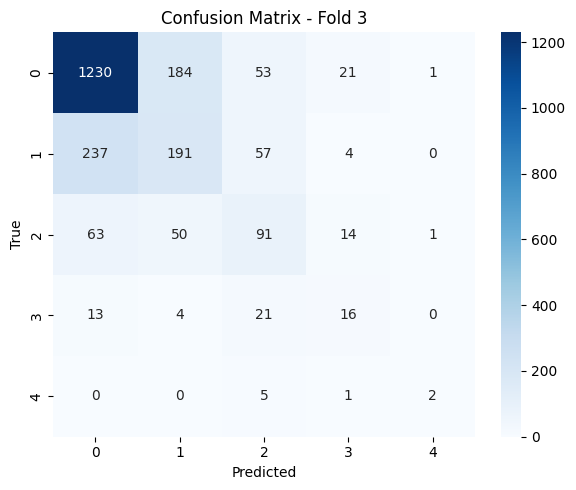

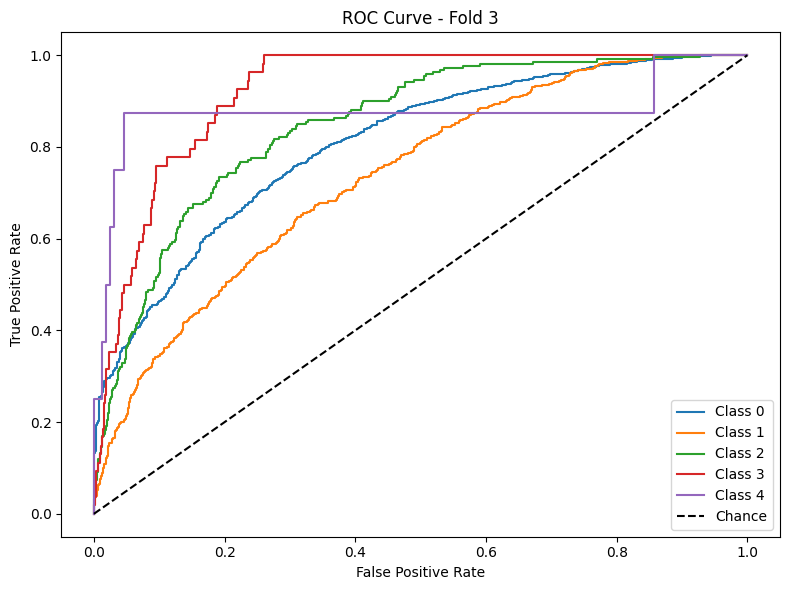

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14736
[LightGBM] [Info] Number of data points in the train set: 26346, number of used features: 64
[LightGBM] [Info] Start training from score -1.486749
[LightGBM] [Info] Start training from score -1.486749
[LightGBM] [Info] Start training from score -1.486749
[LightGBM] [Info] Start training from score -1.486749
[LightGBM] [Info] Start training from score -2.347852
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

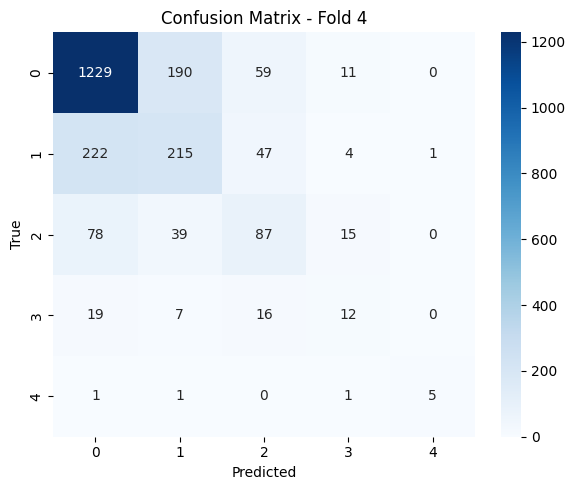

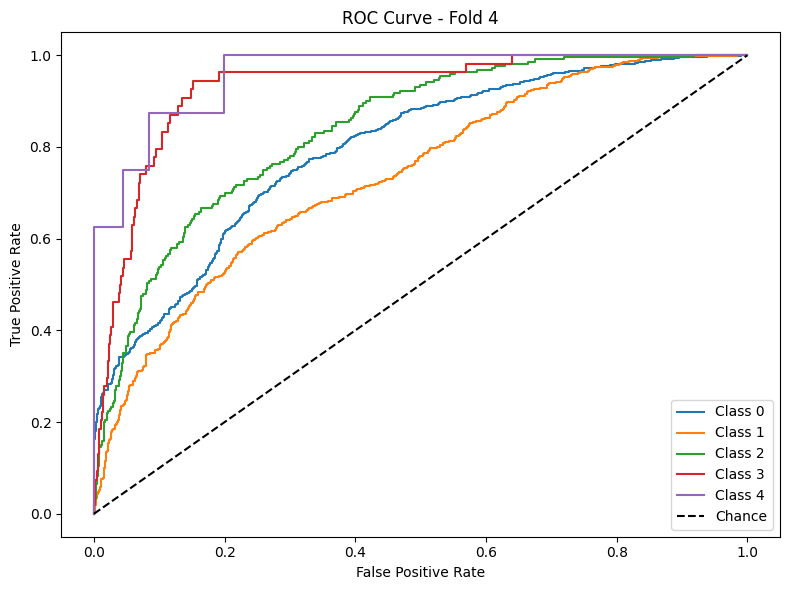

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14889
[LightGBM] [Info] Number of data points in the train set: 26342, number of used features: 64
[LightGBM] [Info] Start training from score -1.486766
[LightGBM] [Info] Start training from score -1.486766
[LightGBM] [Info] Start training from score -1.486766
[LightGBM] [Info] Start training from score -1.486766
[LightGBM] [Info] Start training from score -2.347700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

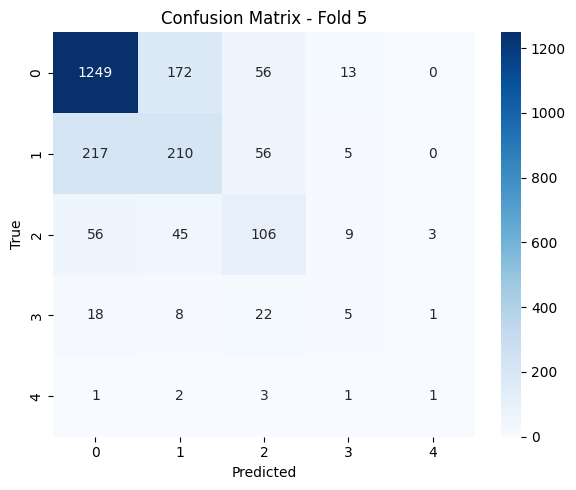

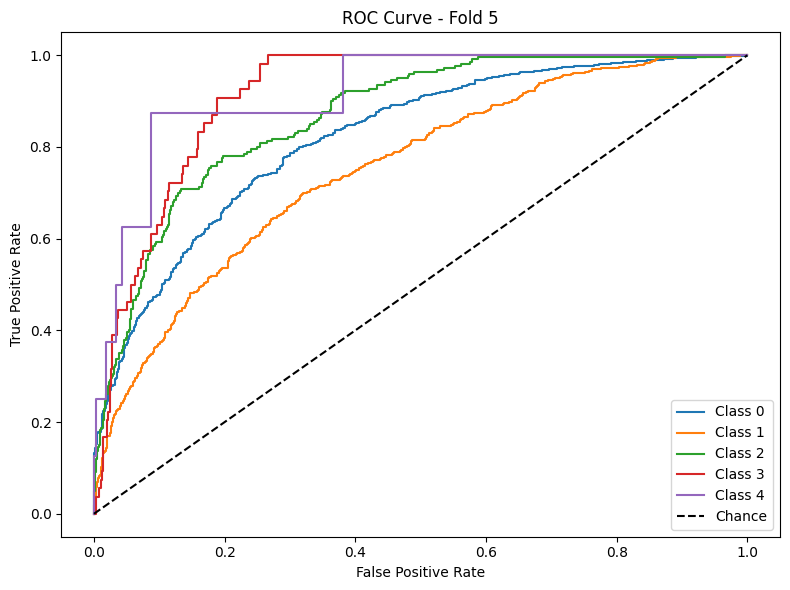


Average Accuracy: 0.6838
Average F1 Macro: 0.4449
Average AUC: 0.8467

Top Feature Importances:
remaining_time     14391
combined_emb_14    11481
combined_emb_11    11447
combined_emb_0     11439
combined_emb_2     11213
combined_emb_13    11125
combined_emb_4     10717
combined_emb_3     10661
combined_emb_10    10641
combined_emb_6     10614
dtype: int32

=== Training Phase 3 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

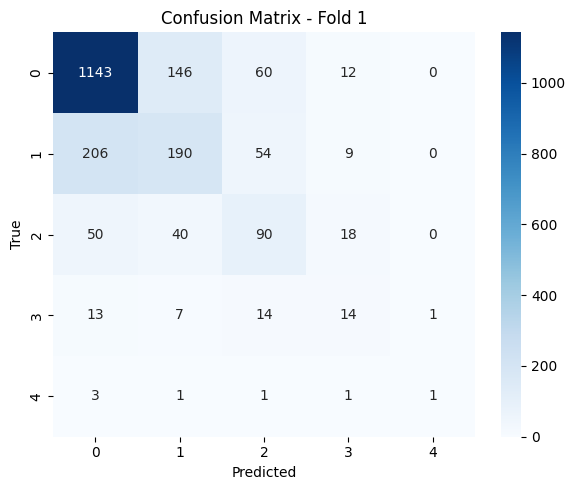

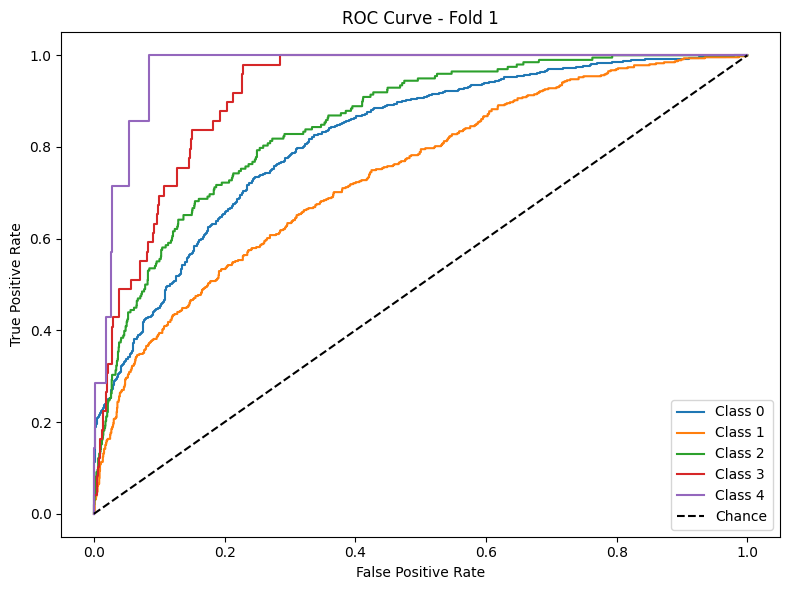

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17396
[LightGBM] [Info] Number of data points in the train set: 24063, number of used features: 80
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -2.348201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

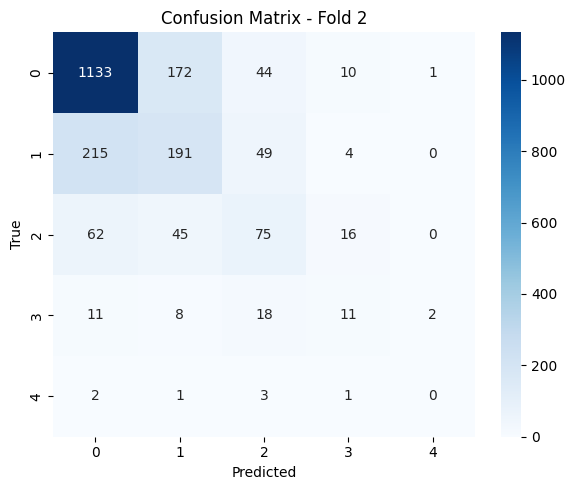

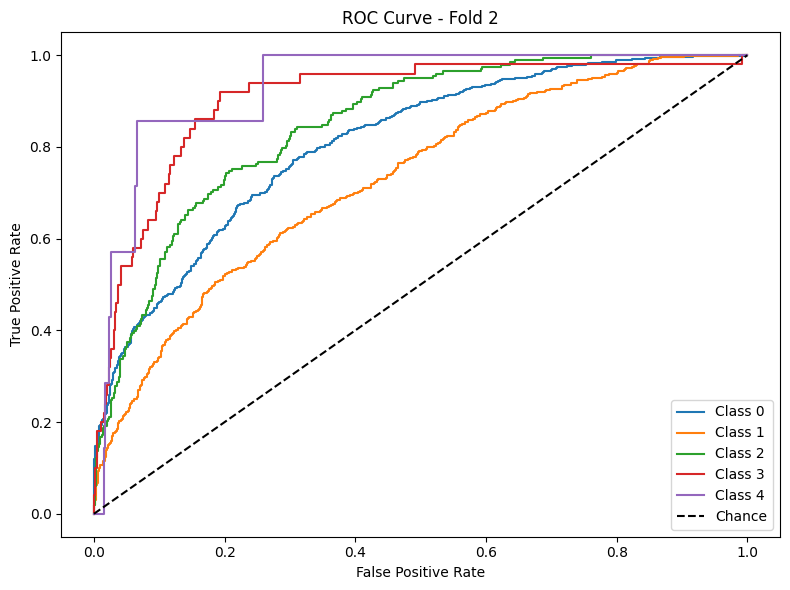

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16585
[LightGBM] [Info] Number of data points in the train set: 24063, number of used features: 79
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -2.348201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

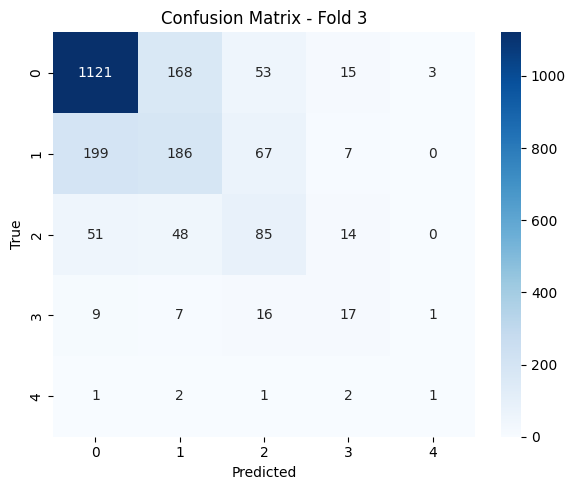

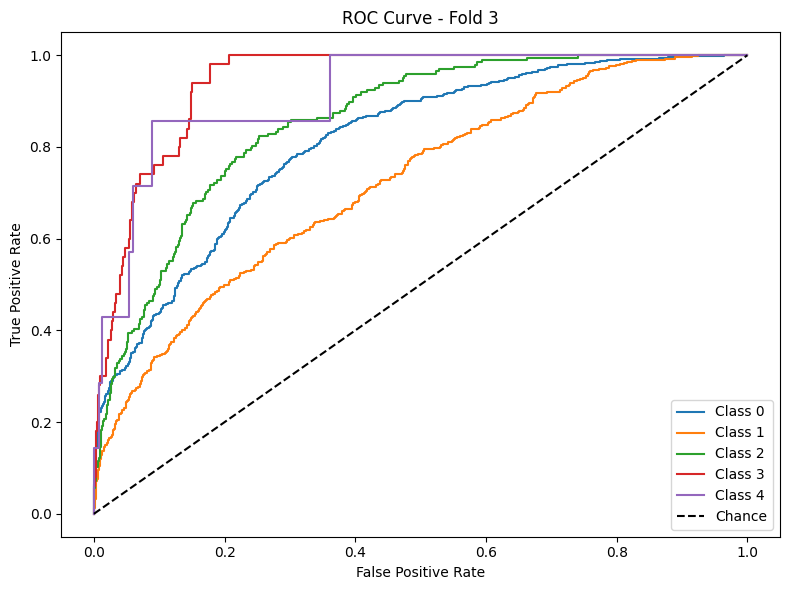

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16906
[LightGBM] [Info] Number of data points in the train set: 24063, number of used features: 80
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -2.348201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

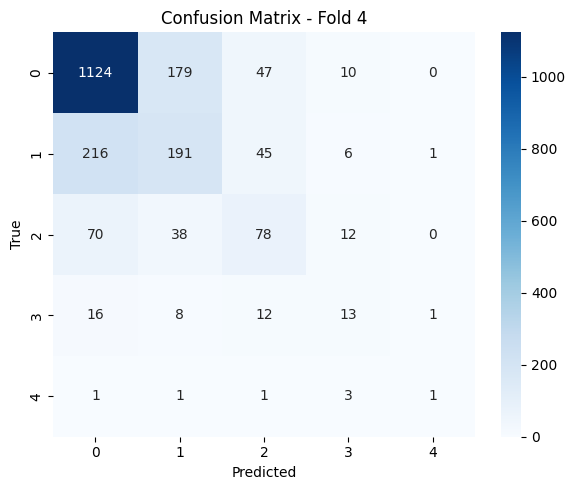

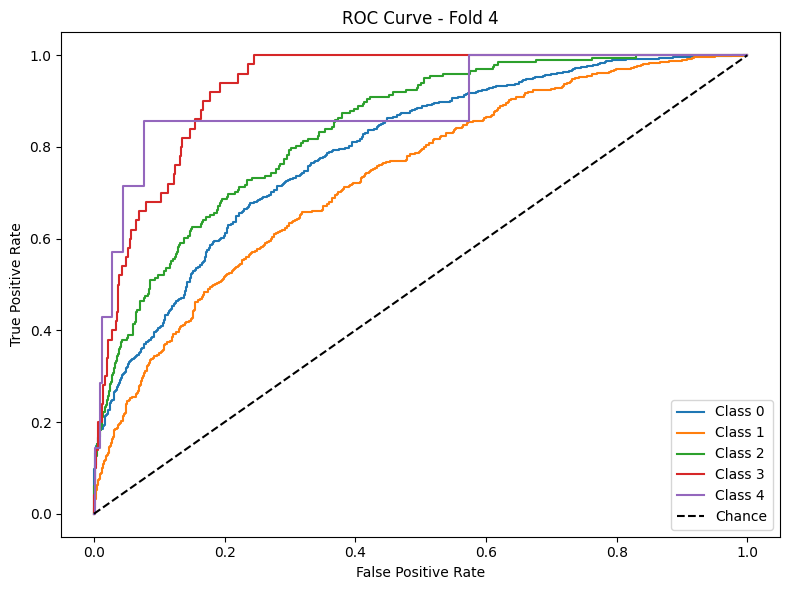

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16973
[LightGBM] [Info] Number of data points in the train set: 24063, number of used features: 80
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -2.348201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

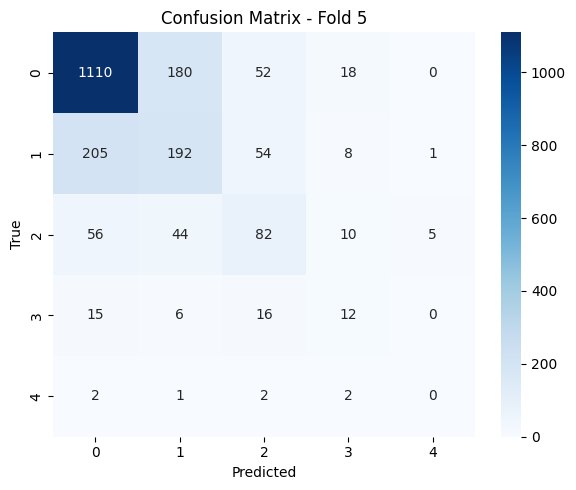

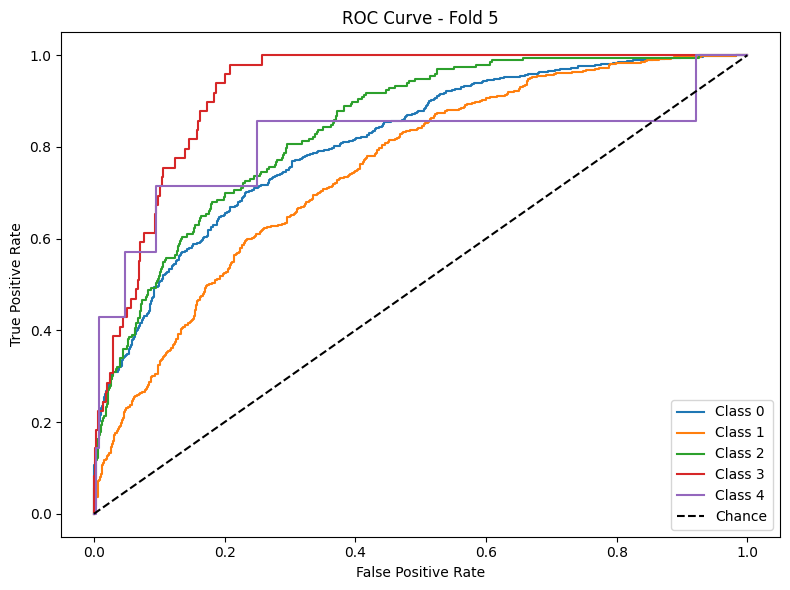


Average Accuracy: 0.6810
Average F1 Macro: 0.4095
Average AUC: 0.8437

Top Feature Importances:
remaining_time     5722
combined_emb_4     5120
combined_emb_6     5037
combined_emb_3     4474
combined_emb_13    4429
combined_emb_11    4349
combined_emb_0     4333
combined_emb_12    4257
combined_emb_14    4244
combined_emb_1     4225
dtype: int32

=== Training Phase 4 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

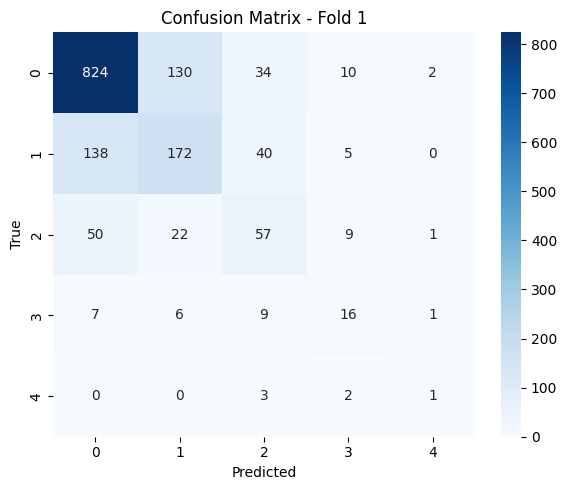

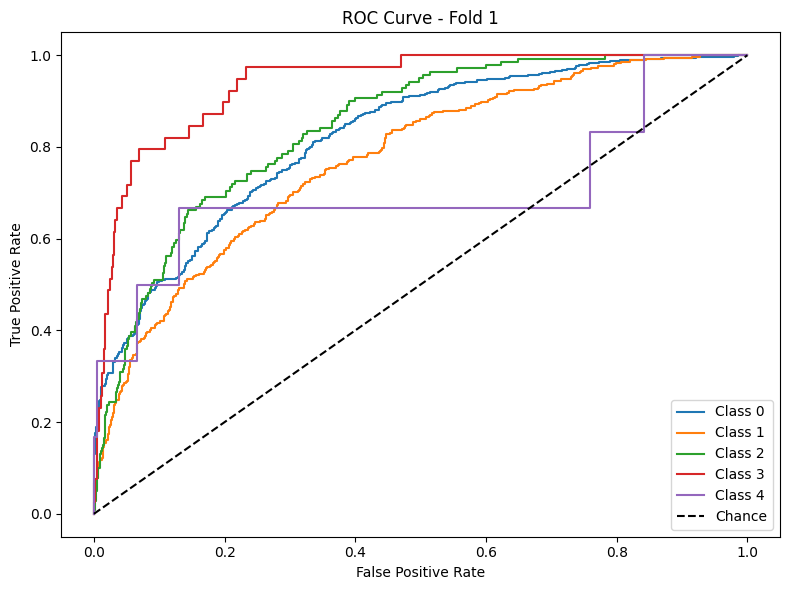

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19544
[LightGBM] [Info] Number of data points in the train set: 17679, number of used features: 95
[LightGBM] [Info] Start training from score -1.486833
[LightGBM] [Info] Start training from score -1.486833
[LightGBM] [Info] Start training from score -1.486833
[LightGBM] [Info] Start training from score -1.486833
[LightGBM] [Info] Start training from score -2.347057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

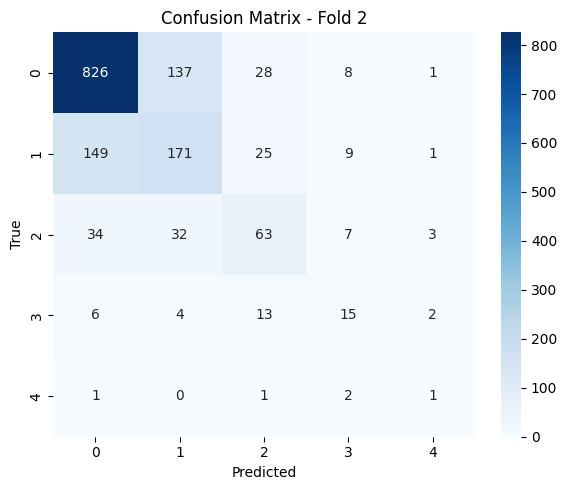

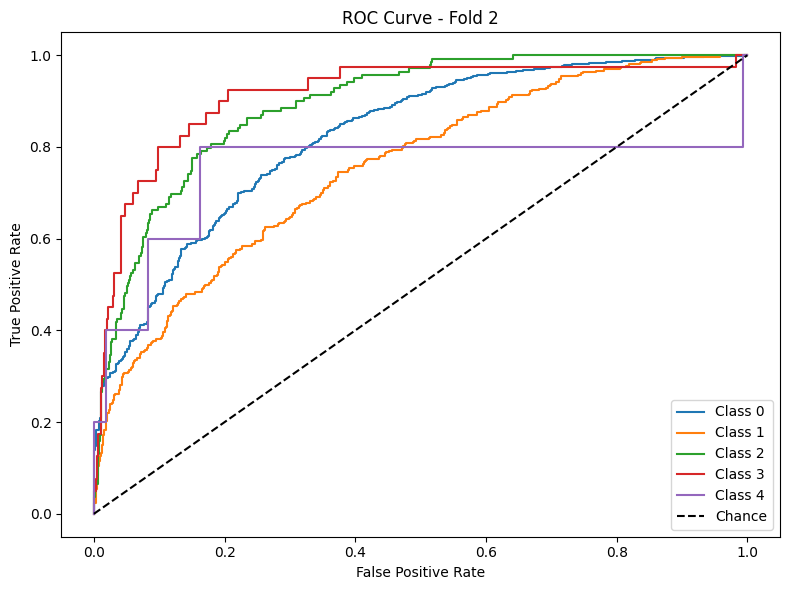

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19958
[LightGBM] [Info] Number of data points in the train set: 17683, number of used features: 95
[LightGBM] [Info] Start training from score -1.486809
[LightGBM] [Info] Start training from score -1.486809
[LightGBM] [Info] Start training from score -1.486809
[LightGBM] [Info] Start training from score -1.486809
[LightGBM] [Info] Start training from score -2.347284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

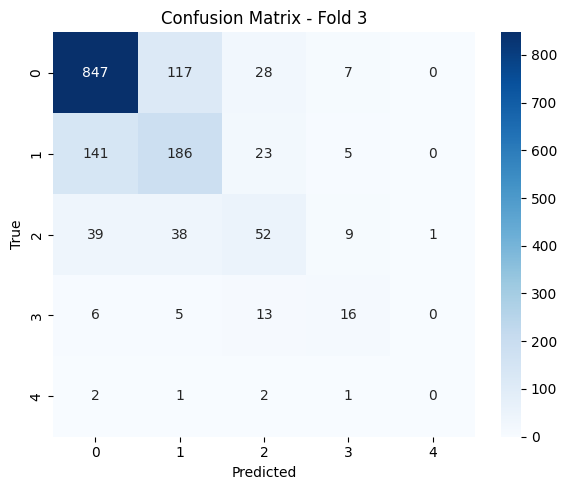

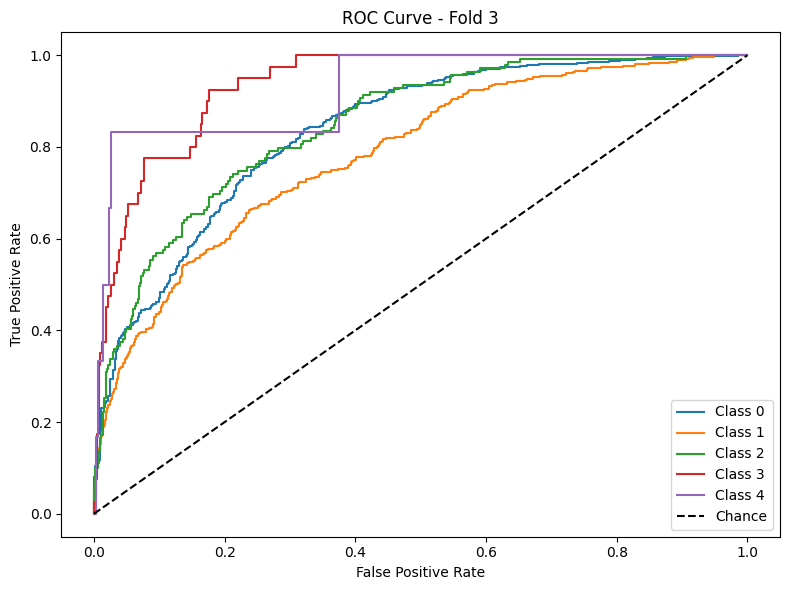

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20001
[LightGBM] [Info] Number of data points in the train set: 17683, number of used features: 95
[LightGBM] [Info] Start training from score -1.486809
[LightGBM] [Info] Start training from score -1.486809
[LightGBM] [Info] Start training from score -1.486809
[LightGBM] [Info] Start training from score -1.486809
[LightGBM] [Info] Start training from score -2.347284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

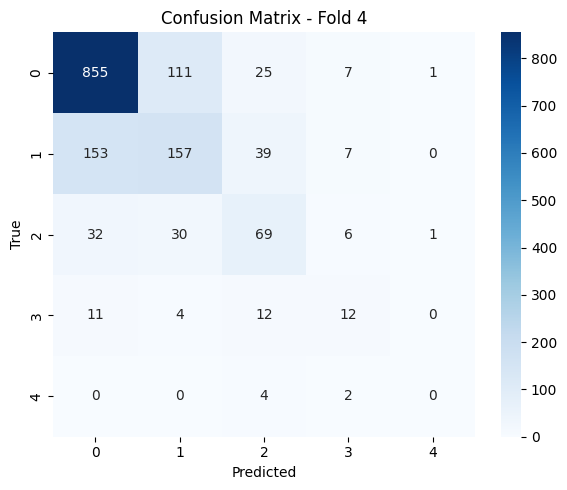

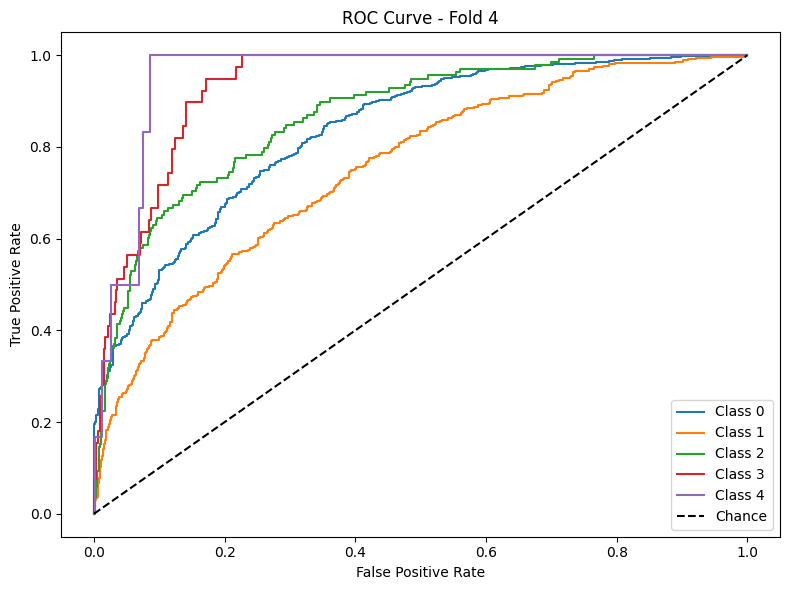

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17177
[LightGBM] [Info] Number of data points in the train set: 17683, number of used features: 95
[LightGBM] [Info] Start training from score -1.486809
[LightGBM] [Info] Start training from score -1.486809
[LightGBM] [Info] Start training from score -1.486809
[LightGBM] [Info] Start training from score -1.486809
[LightGBM] [Info] Start training from score -2.347284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

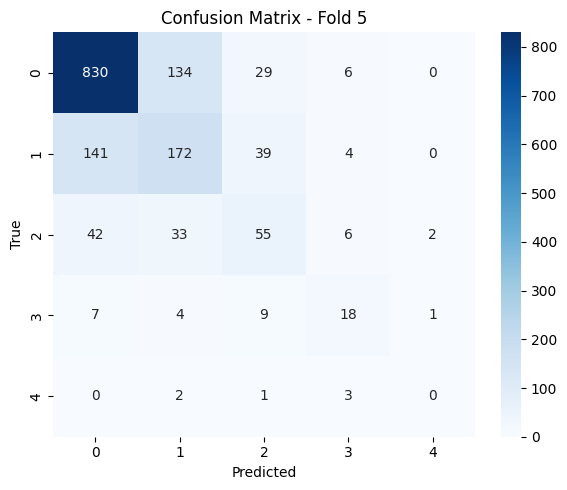

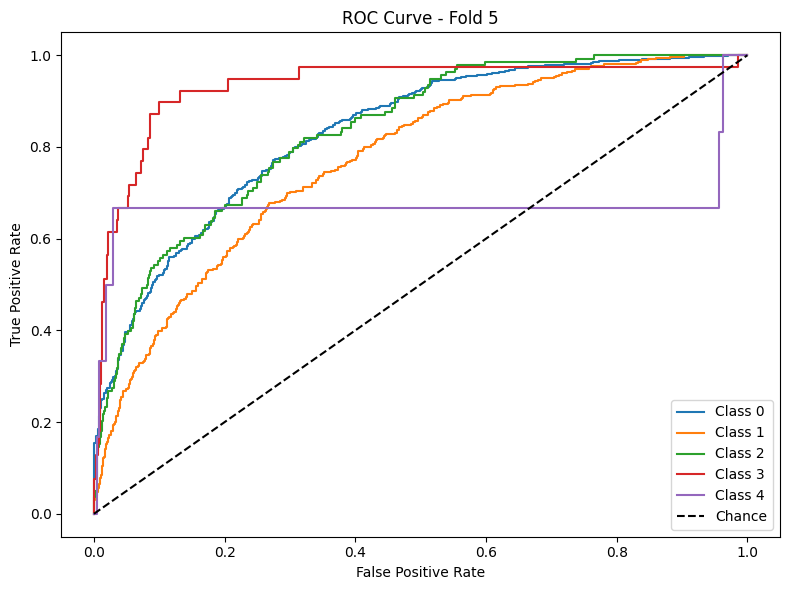


Average Accuracy: 0.7039
Average F1 Macro: 0.4437
Average AUC: 0.8367

Top Feature Importances:
remaining_time     12182
combined_emb_4     10651
combined_emb_8     10223
combined_emb_12    10220
combined_emb_1     10007
combined_emb_0      9923
combined_emb_11     9908
combined_emb_9      9514
combined_emb_6      9476
combined_emb_7      9353
dtype: int32


In [8]:
phase_paths = [f"/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n=== Training Phase {i} ===")
    sample = True
    model, scaler, best_fold, metrics = train_phase(phase_path, param_dist, sample = sample)
    # Save best model & scaler
    if sample: 
        temp = "sample"
    else: temp = "no_sample"
    joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    results[f"phase{i}"] = metrics



Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.95      0.91       568
           1       0.37      0.27      0.31        63
           2       0.33      0.26      0.29        43
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         9

    accuracy                           0.82       698
   macro avg       0.32      0.30      0.30       698
weighted avg       0.77      0.82      0.79       698



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


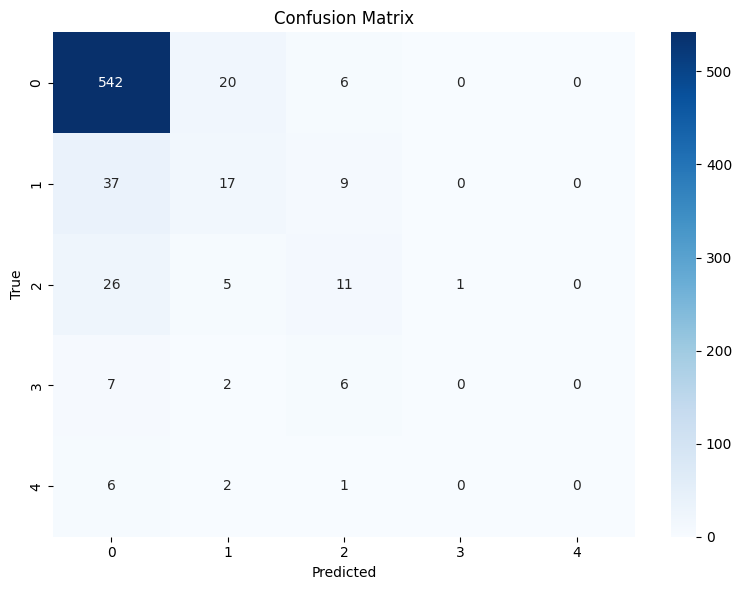


Test AUC (macro-average, OVR): 0.8477


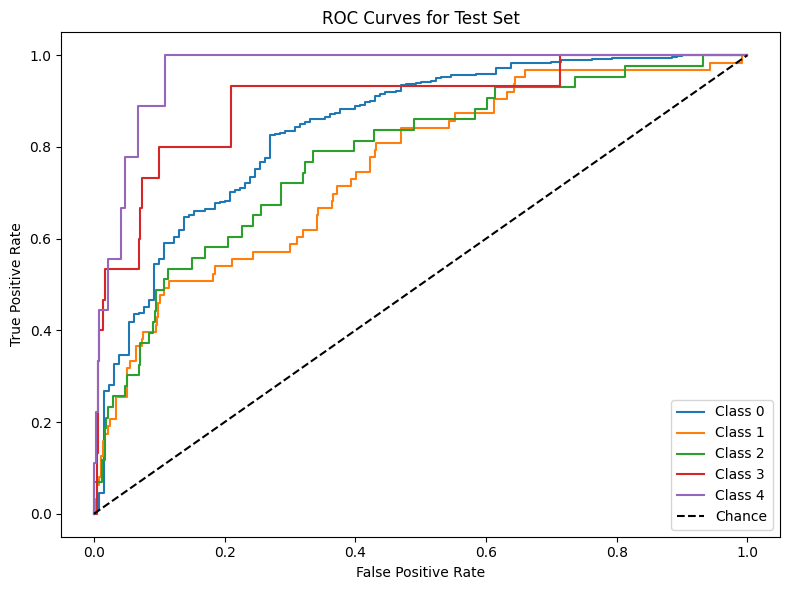


Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       544
           1       0.35      0.24      0.28        59
           2       0.28      0.19      0.23        42
           3       0.00      0.00      0.00        14
           4       0.33      0.11      0.17         9

    accuracy                           0.82       668
   macro avg       0.37      0.30      0.32       668
weighted avg       0.77      0.82      0.79       668



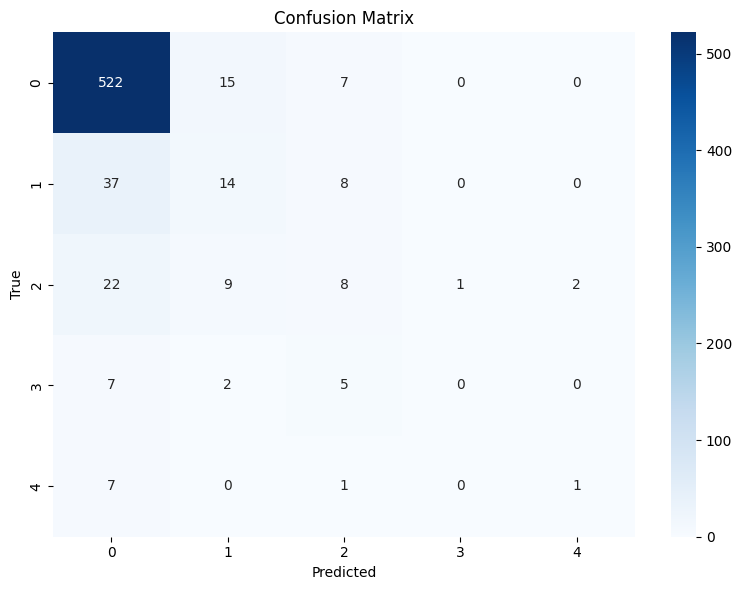


Test AUC (macro-average, OVR): 0.8362


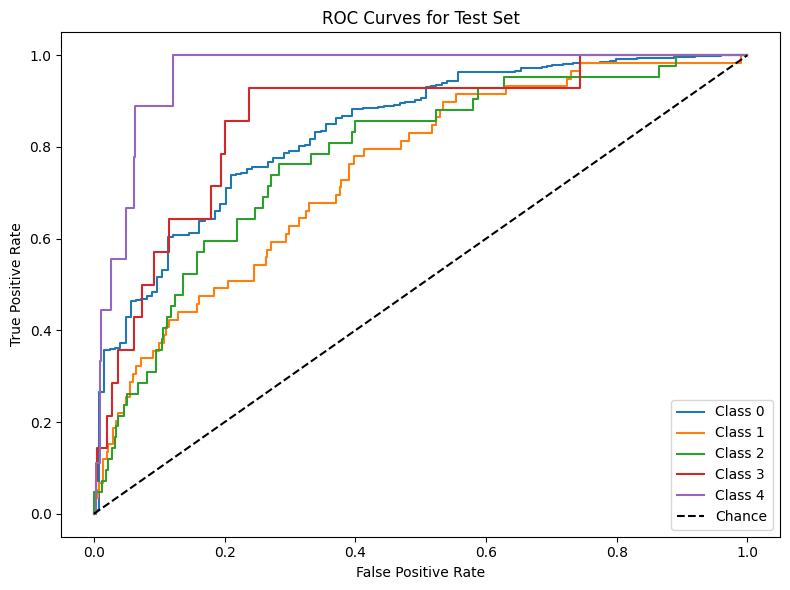


Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.98      0.92       455
           1       0.32      0.17      0.23        52
           2       0.25      0.10      0.15        29
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.82       554
   macro avg       0.29      0.25      0.26       554
weighted avg       0.76      0.82      0.78       554



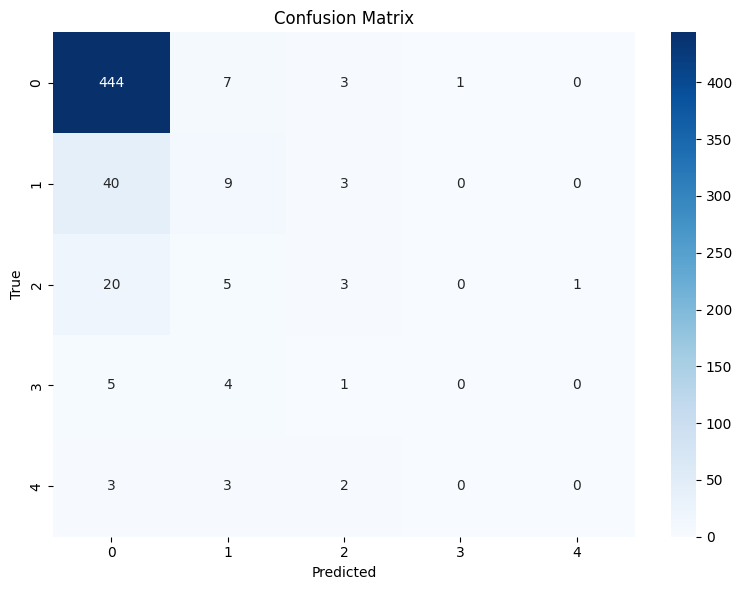


Test AUC (macro-average, OVR): 0.8233


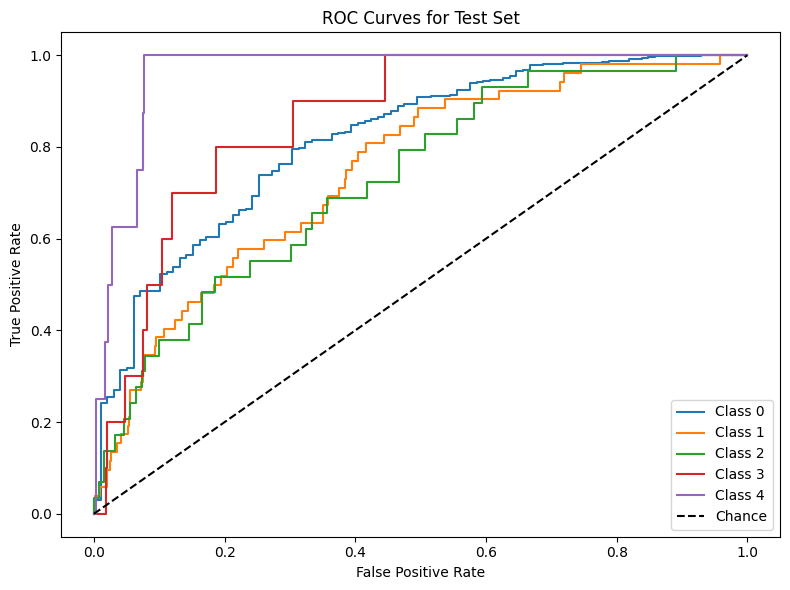


Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.91      0.90       395
           1       0.12      0.12      0.12        40
           2       0.12      0.12      0.12        24
           3       1.00      0.10      0.18        10
           4       0.00      0.00      0.00         8

    accuracy                           0.78       477
   macro avg       0.42      0.25      0.27       477
weighted avg       0.77      0.78      0.76       477



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


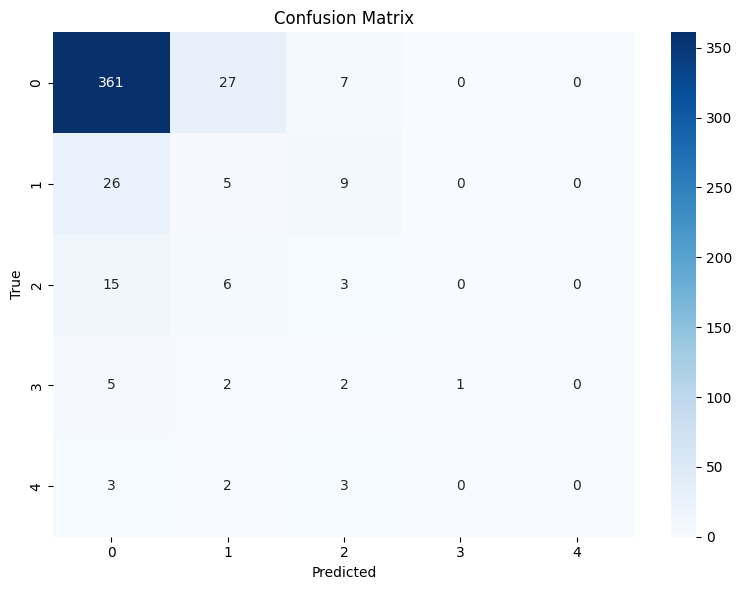


Test AUC (macro-average, OVR): 0.7557


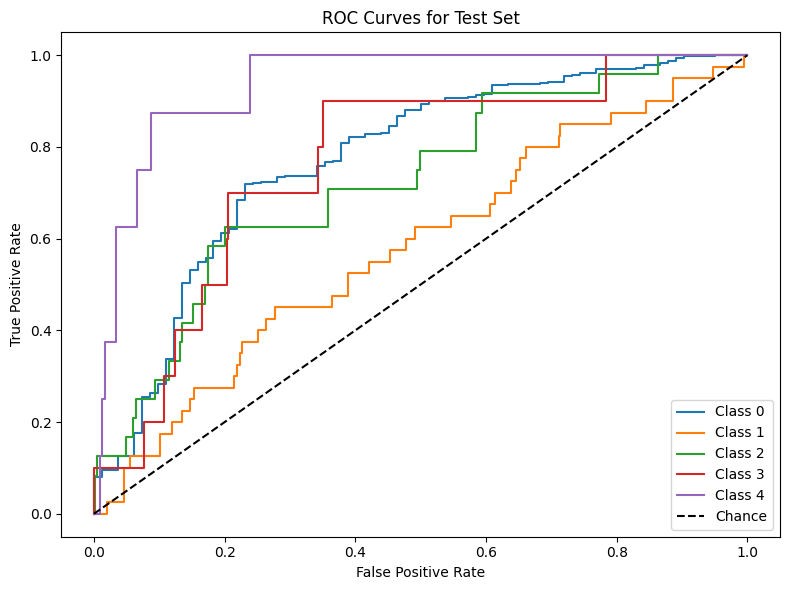

In [9]:
import glob

for i in range(1, 5):
    test_dir = f'/kaggle/input/enrich-data-using-node2vector/phase{i}/user_train_phase_{i}_test.csv'
    
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)
